In [1]:
import ipywidgets as widgets
widgets.Widget.widget_types

# Importing Libraries



In [ ]:
!pip install vaderSentiment

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint,uniform
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,label_binarize,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.combine import SMOTETomek,SMOTEENN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE,SMOTENC,BorderlineSMOTE,ADASYN
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay,roc_curve,auc,f1_score
from sklearn.preprocessing import StandardScaler
import requests
import time
from datetime import datetime, timedelta
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import joblib

# Fetching Stock Data

In [ ]:
stock="TSLA"
df=yf.download(stock,interval='1m',period='8d')

/tmp/ipython-input-1205-3466948560.py:2: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.shape

(3079, 6)

In [ ]:
df.head()

Price,Datetime,Close,High,Low,Open,Volume
Ticker,,TSLA,TSLA,TSLA,TSLA,TSLA
0,2025-06-13 13:30:00+00:00,314.665009,315.980011,313.299988,314.000000,5592548
1,2025-06-13 13:31:00+00:00,315.229706,315.229706,313.609985,314.670013,524622
2,2025-06-13 13:32:00+00:00,316.394989,316.589996,314.570007,315.204987,606619
3,2025-06-13 13:33:00+00:00,316.470001,317.100006,315.250000,316.331207,644879
4,2025-06-13 13:34:00+00:00,316.880005,317.500000,316.160004,316.369995,551840


In [ ]:
df.tail()

Price,Datetime,Close,High,Low,Open,Volume
Ticker,,TSLA,TSLA,TSLA,TSLA,TSLA
3074,2025-06-25 19:55:00+00:00,327.709991,327.849915,327.100006,327.304993,317851
3075,2025-06-25 19:56:00+00:00,327.600006,327.799988,327.500000,327.720001,254944
3076,2025-06-25 19:57:00+00:00,327.403107,327.700012,327.350006,327.589996,262972
3077,2025-06-25 19:58:00+00:00,327.660004,327.690002,327.380005,327.410004,406724
3078,2025-06-25 19:59:00+00:00,327.589996,327.799988,327.350006,327.630005,901340


In [ ]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
count,3079.000000,3079.000000,3079.000000,3079.000000,3.079000e+03
mean,329.754586,330.072777,329.429525,329.755684,2.829572e+05
std,10.690894,10.737654,10.654365,10.697492,3.394362e+05
min,314.290009,314.690002,313.299988,314.000000,1.681000e+03
25%,322.427048,322.744247,322.104996,322.420013,1.384940e+05
50%,325.830109,326.130402,325.589996,325.839996,2.037330e+05
75%,334.300705,335.129990,333.427795,334.270004,3.273620e+05
max,357.429993,357.470001,356.839996,357.049988,7.598903e+06


In [ ]:
df.dtypes

,,0
Price,Ticker,
Datetime,,"datetime64[ns, UTC]"
Close,TSLA,float64
High,TSLA,float64
Low,TSLA,float64
Open,TSLA,float64
Volume,TSLA,int64


In [ ]:
df.to_csv("TSLA.csv")

In [ ]:
data=pd.read_csv("TSLA.csv")

In [ ]:
fig=go.Figure(data=[go.Candlestick(x=data['Datetime'],open=data['Open'],close=data['Close'],high=data['High'],low=data['Low'])])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

# Fetching Sentiment Data

In [ ]:
STOCK_SYMBOL = "TSLA"
NEWSAPI_KEY = "5e9de13b751c4893b87ba28177423d5f"
SENTIMENT_RESOLUTION = "hourly"

In [ ]:
sentiment_analyzer = pipeline("text-classification", model="yiyanghkust/finbert-tone")

Device set to use cuda:0


In [ ]:
vader_analyzer = SentimentIntensityAnalyzer()

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime']).dt.tz_localize(None)

In [ ]:
def fetch_news_with_retry(stock, time_window):
    url = "https://newsapi.org/v2/everything"
    params = {
        "q": f"{stock} stock",
        "from": (time_window - timedelta(hours=1)).strftime('%Y-%m-%dT%H:%M:%S'),
        "to": time_window.strftime('%Y-%m-%dT%H:%M:%S'),
        "language": "en",
        "pageSize": 10,
        "sortBy": "publishedAt",
        "apiKey": NEWSAPI_KEY
    }

    for attempt in range(3):
        try:
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            return response.json().get('articles', [])
        except requests.exceptions.RequestException as e:
            if "429" in str(e):
                print("NewsAPI rate limit exceeded. Skipping sentiment for this time window.")
                return []
            print(f"Retrying... ({str(e)})")
            time.sleep(5 * (attempt + 1))
    return []

In [ ]:
def calculate_sentiment(text):

    if not text or len(text) < 10:
        return 0.0, 0.0, 0.0

    try:

        finbert_result = sentiment_analyzer(text[:512])[0]
        finbert_score = finbert_result['score'] if finbert_result['label'] == 'Positive' else -finbert_result['score']


        textblob_score = TextBlob(text).sentiment.polarity


        vader_score = vader_analyzer.polarity_scores(text)['compound']

        return finbert_score, textblob_score, vader_score
    except Exception as e:
        print(f"Sentiment error: {str(e)}")
        return 0.0, 0.0, 0.0

In [ ]:
df['sentimentfinbert'] = 0.0
df['sentimenttextblob'] = 0.0
df['sentimentvader'] = 0.0
if SENTIMENT_RESOLUTION == "hourly":
    time_groups = df.groupby([df['Datetime'].dt.date, df['Datetime'].dt.hour])
else:
    time_groups = df.groupby(df['Datetime'].dt.date)

for (date, *hour), group in time_groups:
    if SENTIMENT_RESOLUTION == "hourly":
        window_time = datetime.combine(date, datetime.min.time()).replace(hour=hour[0])
    else:
        window_time = datetime.combine(date, datetime.min.time())

    articles = fetch_news_with_retry(STOCK_SYMBOL, window_time)

    if not articles:
        continue


    finbert_scores = []
    textblob_scores = []
    vader_scores = []

    for article in articles:
        title = article.get('title', '')
        description = article.get('description', '')


        finbert_title, textblob_title, vader_title = calculate_sentiment(title)
        finbert_desc, textblob_desc, vader_desc = calculate_sentiment(description)


        finbert_combined = (finbert_title * 0.6) + (finbert_desc * 0.4)
        textblob_combined = (textblob_title * 0.6) + (textblob_desc * 0.4)
        vader_combined = (vader_title * 0.6) + (vader_desc * 0.4)

        finbert_scores.append(finbert_combined)
        textblob_scores.append(textblob_combined)
        vader_scores.append(vader_combined)

    if finbert_scores:
        df.loc[group.index, 'sentimentfinbert'] = np.mean(finbert_scores)
        df.loc[group.index, 'sentimenttextblob'] = np.mean(textblob_scores)
        df.loc[group.index, 'sentimentvader'] = np.mean(vader_scores)

NewsAPI rate limit exceeded. Skipping sentiment for this time window.
NewsAPI rate limit exceeded. Skipping sentiment for this time window.
NewsAPI rate limit exceeded. Skipping sentiment for this time window.
NewsAPI rate limit exceeded. Skipping sentiment for this time window.
NewsAPI rate limit exceeded. Skipping sentiment for this time window.
NewsAPI rate limit exceeded. Skipping sentiment for this time window.
NewsAPI rate limit exceeded. Skipping sentiment for this time window.
NewsAPI rate limit exceeded. Skipping sentiment for this time window.
NewsAPI rate limit exceeded. Skipping sentiment for this time window.
NewsAPI rate limit exceeded. Skipping sentiment for this time window.
NewsAPI rate limit exceeded. Skipping sentiment for this time window.
NewsAPI rate limit exceeded. Skipping sentiment for this time window.
NewsAPI rate limit exceeded. Skipping sentiment for this time window.
NewsAPI rate limit exceeded. Skipping sentiment for this time window.
NewsAPI rate limit e

In [ ]:
df = df[['Datetime', 'Close', 'High', 'Low', 'Open', 'sentimentfinbert','sentimenttextblob','sentimentvader']]

In [ ]:
input_columns=['Datetime', 'Close', 'High', 'Low', 'Open', 'sentimentfinbert','sentimenttextblob','sentimentvader']

In [ ]:
df.head()

Price,Datetime,Close,High,Low,Open,sentimentfinbert,sentimenttextblob,sentimentvader
Ticker,,TSLA,TSLA,TSLA,TSLA,,,
0,2025-06-13 13:30:00,314.665009,315.980011,313.299988,314.000000,0.0,0.0,0.0
1,2025-06-13 13:31:00,315.229706,315.229706,313.609985,314.670013,0.0,0.0,0.0
2,2025-06-13 13:32:00,316.394989,316.589996,314.570007,315.204987,0.0,0.0,0.0
3,2025-06-13 13:33:00,316.470001,317.100006,315.250000,316.331207,0.0,0.0,0.0
4,2025-06-13 13:34:00,316.880005,317.500000,316.160004,316.369995,0.0,0.0,0.0


In [ ]:
df.tail()

Price,Datetime,Close,High,Low,Open,sentimentfinbert,sentimenttextblob,sentimentvader
Ticker,,TSLA,TSLA,TSLA,TSLA,,,
3074,2025-06-25 19:55:00,327.709991,327.849915,327.100006,327.304993,0.0,0.0,0.0
3075,2025-06-25 19:56:00,327.600006,327.799988,327.500000,327.720001,0.0,0.0,0.0
3076,2025-06-25 19:57:00,327.403107,327.700012,327.350006,327.589996,0.0,0.0,0.0
3077,2025-06-25 19:58:00,327.660004,327.690002,327.380005,327.410004,0.0,0.0,0.0
3078,2025-06-25 19:59:00,327.589996,327.799988,327.350006,327.630005,0.0,0.0,0.0


In [ ]:
df.describe()

Price,Datetime,Close,High,Low,Open,sentimentfinbert,sentimenttextblob,sentimentvader
Ticker,,TSLA,TSLA,TSLA,TSLA,,,
count,3079,3079.000000,3079.000000,3079.000000,3079.000000,3079.0,3079.0,3079.0
mean,2025-06-20 04:03:12.491068416,329.754586,330.072777,329.429525,329.755684,0.0,0.0,0.0
min,2025-06-13 13:30:00,314.290009,314.690002,313.299988,314.000000,0.0,0.0,0.0
25%,2025-06-16 19:49:30,322.427048,322.744247,322.104996,322.420013,0.0,0.0,0.0
50%,2025-06-18 19:51:00,325.830109,326.130402,325.589996,325.839996,0.0,0.0,0.0
75%,2025-06-23 19:53:30,334.300705,335.129990,333.427795,334.270004,0.0,0.0,0.0
max,2025-06-25 19:59:00,357.429993,357.470001,356.839996,357.049988,0.0,0.0,0.0
std,NaN,10.690894,10.737654,10.654365,10.697492,0.0,0.0,0.0


In [ ]:
df.shape

(3079, 8)

# Detect CandleStick Pattern

In [ ]:
period = 3
df['SMA'] = df['Close'].rolling(period).mean()
df['SMA'] = pd.to_numeric(df['SMA'], errors='coerce')
df['trend'] = (df['SMA'] - df['SMA'].shift(1)) > 0

In [ ]:
df['trend'] = df['trend'].fillna(False)

In [ ]:
df

Price,Datetime,Close,High,Low,Open,sentimentfinbert,sentimenttextblob,sentimentvader,SMA,trend
Ticker,,TSLA,TSLA,TSLA,TSLA,,,,,
0,2025-06-13 13:30:00,314.665009,315.980011,313.299988,314.000000,0.0,0.0,0.0,NaN,False
1,2025-06-13 13:31:00,315.229706,315.229706,313.609985,314.670013,0.0,0.0,0.0,NaN,False
2,2025-06-13 13:32:00,316.394989,316.589996,314.570007,315.204987,0.0,0.0,0.0,315.429901,False
3,2025-06-13 13:33:00,316.470001,317.100006,315.250000,316.331207,0.0,0.0,0.0,316.031565,True
4,2025-06-13 13:34:00,316.880005,317.500000,316.160004,316.369995,0.0,0.0,0.0,316.581665,True
...,...,...,...,...,...,...,...,...,...,...
3074,2025-06-25 19:55:00,327.709991,327.849915,327.100006,327.304993,0.0,0.0,0.0,327.577271,True
3075,2025-06-25 19:56:00,327.600006,327.799988,327.500000,327.720001,0.0,0.0,0.0,327.538635,False
3076,2025-06-25 19:57:00,327.403107,327.700012,327.350006,327.589996,0.0,0.0,0.0,327.571035,True


In [ ]:
print(type(df['trend']))
print(df['trend'].head())

<class 'pandas.core.series.Series'>
0    False
1    False
2    False
3     True
4     True
Name: trend, dtype: bool


In [ ]:
print("Condition 1: ", type(df['Close'] > df['Open']))
print("Condition 2: ", type(df['Open'].shift(2) > df['Close'].shift(2)))
print("Condition 3: ", type(df['Close'] > df['Close'].shift(1)))
print("Condition 4: ", type(df['Close'].shift(1) < df['Open'].shift(1)))
print("Condition 5: ", type(df['Open'].shift(1) < df['Open']))
print("Condition 6: ", type(df['Close'] > (df['Open'] + df['Close']) / 2))
print("Condition 7: ", type(df['Close'].shift(1) < df['Close'].shift(2)))
print("Condition 8: ", type(df['Open'].shift(1) < df['Close'].shift(2)))
print("Condition 9: ", type(~df['trend']))


Condition 1:  <class 'pandas.core.frame.DataFrame'>
Condition 2:  <class 'pandas.core.frame.DataFrame'>
Condition 3:  <class 'pandas.core.frame.DataFrame'>
Condition 4:  <class 'pandas.core.frame.DataFrame'>
Condition 5:  <class 'pandas.core.frame.DataFrame'>
Condition 6:  <class 'pandas.core.frame.DataFrame'>
Condition 7:  <class 'pandas.core.frame.DataFrame'>
Condition 8:  <class 'pandas.core.frame.DataFrame'>
Condition 9:  <class 'pandas.core.series.Series'>


In [ ]:
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

In [ ]:
df.columns

Index(['Datetime_', 'Close_TSLA', 'High_TSLA', 'Low_TSLA', 'Open_TSLA',
       'sentimentfinbert_', 'sentimenttextblob_', 'sentimentvader_', 'SMA_',
       'trend_'],
      dtype='object')

In [ ]:
df.columns = [col.split('_')[0] for col in df.columns]

In [ ]:
df.columns

Index(['Datetime', 'Close', 'High', 'Low', 'Open', 'sentimentfinbert',
       'sentimenttextblob', 'sentimentvader', 'SMA', 'trend'],
      dtype='object')

**CANDLESTICK** **PATTERN**



*  Morning Star


In [ ]:
df['Morning_star'] = (
     (df['Close'] > df['Open']) &
    (df['Open'].shift(2) > df['Close'].shift(2)) &
    (df['Close'] > df['Close'].shift(1)) &
    (df['Close'].shift(1) < df['Open'].shift(1)) &
    (df['Open'].shift(1) < df['Open']) &
    (df['Close'] > (df['Open'] + df['Close']) / 2) &
    (df['Close'].shift(1) < df['Close'].shift(2)) &
    (df['Open'].shift(1) < df['Close'].shift(2)) &
    (~df['trend'])
)


In [ ]:
df['Morning_star'].value_counts()

,count
Morning_star,
False,3077
True,2




*   Evening Star



In [ ]:
df['Evening_star']=((df['Close'].shift(2)>df['Open'].shift(2))&
(df['Open']>df['Close'])&
(df['Close']<(df['Close'].shift(2)+df['Open'].shift(2))/2)&
(df['Open'].shift(1)>df['Close'].shift(2))&
(df['Close'].shift(1)>df['Close'].shift(2))&
(df['Open'].shift(1)>df['Open'])&
(df['Close'].shift(1)>df['Open'])&
(df['trend']))

In [ ]:
df['Evening_star'].value_counts()

,count
Evening_star,
False,3077
True,2




*   Bullish Harami



In [ ]:
df['Bullish_harami']=((df['Close']<df['Open'].shift(1))&
(df['Open']>df['Close'].shift(1))&
(df['Close']>df['Open'])&
(df['Open'].shift(1)>df['Close'].shift(1))&
(~df['trend']))

In [ ]:
df['Bullish_harami'].value_counts()

,count
Bullish_harami,
False,2981
True,98




*   Bearish Harami




In [ ]:
df['Bearish_harami']=((df['Close']>df['Open'].shift(1))&
(df['Open']<df['Close'].shift(1))&
(df['Close']<df['Open'])&
(df['Close'].shift(1)>df['Open'].shift(1))&
(df['trend'])
)

In [ ]:
df['Bearish_harami'].value_counts()

,count
Bearish_harami,
False,2953
True,126




*   Green Hammer



In [ ]:
df['Green_hammer']=(
        (df['Close'] > df['Open']) &
        ((df['Open'] - df['Low']) >= 2 * (df['Close'] - df['Open'])) &
        ((df['High'] - df['Close']) <= 0.3 * (df['Close'] - df['Open']))&
        (~df['trend'])
    )

In [ ]:
df['Green_hammer'].value_counts()

,count
Green_hammer,
False,3063
True,16




*  Red Hammer



In [ ]:
df['Red_hammer']= (
        (df['Close'] < df['Open']) &
        ((df['Close'] - df['Low']) >= 2 * (df['Open'] - df['Close'])) &
        ((df['High'] - df['Open']) <= 0.3 * (df['Open'] - df['Close']))&
        (~df['trend'])
    )

In [ ]:
df['Red_hammer'].value_counts()

,count
Red_hammer,
False,3055
True,24




*   Bull Kicker



In [ ]:
df['Bull_kicker']=((abs(df['Open'].shift(1)-df['Open'])<0.02*df['Open'])&
                   (df['Open'].shift(1)>df['Close'].shift(1))&
                   (df['Close']>df['Open'])&
                   (df['Low']>df['Open'].shift(1))&
                   (~df['trend']))

In [ ]:
df['Bull_kicker'].value_counts()

,count
Bull_kicker,
False,3076
True,3




*   Bear Kicker






In [ ]:
df['Bear_kicker'] = (
    (abs(df['Open'].shift(1) - df['Open']) < 0.002 * df['Open']) &
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Open'] > df['Close']) &
    (df['Open'] < df['Low'].shift(1))&
    (df['trend'])
)

In [ ]:
df['Bear_kicker'].value_counts()

,count
Bear_kicker,
False,3079




*   Green shooting Star



In [ ]:
df['Green_shooting_star']= (
        (df['Close'] > df['Open']) &
        ((df['High'] - df['Close']) >= 2 * (df['Close'] - df['Open'])) &
        ((df['Open'] - df['Low']) <= 0.3 * (df['Close'] - df['Open']))&
        (df['trend'])
    )

In [ ]:
df['Green_shooting_star'].value_counts()

,count
Green_shooting_star,
False,3064
True,15




*   Red shooting Star



In [ ]:
df['Red_shooting_star'] = (
    (df['Close'] < df['Open']) &
    ((df['High'] - df['Close']) >= 2 * (df['Close'] - df['Open'])) &
    ((df['Open'] - df['Low']) <= 0.3 * (df['Close'] - df['Open'])) &
    (df['trend'])
)


In [ ]:
df['Red_shooting_star'].value_counts()

,count
Red_shooting_star,
False,3079




*   Three White Soldiers



In [ ]:
df['Three_White_Soldiers'] = (
    (df['Close'] > df['Open']) &
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Close'].shift(2) > df['Open'].shift(2)) &
    (df['Close'] > df['Close'].shift(1)) &
    (df['Close'].shift(1) > df['Close'].shift(2)) &
    (df['Open'] < df['Close'].shift(1)) &
    (~df['trend'])
)


In [ ]:
df['Three_White_Soldiers'].value_counts()

,count
Three_White_Soldiers,
False,3078
True,1




*   Three Black Crows



In [ ]:
df['Three_Black_Crows'] = (
  (
    (df['Close'] < df['Open']) &
    (df['Close'].shift(1) < df['Open'].shift(1)) &
    (df['Close'].shift(2) < df['Open'].shift(2)) &
    (df['Close'] < df['Close'].shift(1)) &
    (df['Close'].shift(1) < df['Close'].shift(2)) &
    (df['Open'] < df['Close'].shift(1)) &
    (df['trend'])
  )
)

In [ ]:
df['Three_Black_Crows'].value_counts()

,count
Three_Black_Crows,
False,3079




*   Tweezer Tops



In [ ]:
df['Tweezer_Tops'] = (
    (df['High'] == df['High'].shift(1)) &
    (df['Close'] < df['Open']) &
    (df['Close'].shift(1) > df['Open'].shift(1))&
    (df['trend'])
)

In [ ]:
df['Tweezer_Tops'].value_counts()

,count
Tweezer_Tops,
False,3068
True,11




*   Tweezer Bottoms



In [ ]:
df['Tweezer_Bottoms'] = (
    (df['Low'] == df['Low'].shift(1)) &
    (df['Close'] > df['Open']) &
    (df['Close'].shift(1) < df['Open'].shift(1)) &
    (~df['trend'])
)


In [ ]:
df['Tweezer_Bottoms'].value_counts()

,count
Tweezer_Bottoms,
False,3070
True,9




*   Hanging Man



In [ ]:
df['Hanging_Man'] = (
    (df['Close'] < df['Open']) &
    ((df['Open'] - df['Low']) > 2 * (df['Open'] - df['Close'])) &
    ((df['High'] - df['Close']) < 0.5 * (df['Open'] - df['Close']))&
    (df['trend'])
)

In [ ]:
df['Hanging_Man'].value_counts()

,count
Hanging_Man,
False,3079




*   Dark Cloud Cover



In [ ]:
df['Dark_Cloud_Cover'] = (
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Open'] > df['Close'].shift(1)) &
    (df['Close'] < (df['Open'].shift(1) + df['Close'].shift(1)) / 2) &
    (df['Close'] < df['Open'])&
    (df['trend'])
)

In [ ]:
df['Dark_Cloud_Cover'].value_counts()

,count
Dark_Cloud_Cover,
False,3003
True,76




*   Piercing Pattern



In [ ]:
df['Piercing_Pattern'] = (
    (df['Close'].shift(1) < df['Open'].shift(1)) &
    (df['Open'] < df['Close'].shift(1)) &
    (df['Close'] > (df['Open'].shift(1) + df['Close'].shift(1)) / 2) &
    (df['Close'] > df['Open'])&
    (~df['trend'])
)

In [ ]:
df['Piercing_Pattern'].value_counts()

,count
Piercing_Pattern,
False,2992
True,87




*   Doji



In [ ]:
threshold = 0.02
df['Doji'] = np.abs(df['Open'] - df['Close']) <= threshold * (df['High'] - df['Low'])

In [ ]:
df['Doji'].value_counts()

,count
Doji,
False,3015
True,64




*   Bullish_Engulfing



In [ ]:
df['Bullish_Engulfing'] = ((df['Open'].shift(1) > df['Close'].shift(1)) &
                          (df['Open'] < df['Close']) &
                          (df['Open'] < df['Close'].shift(1)) &
                          (df['Close'] > df['Open'].shift(1))&
                           (~df['trend']))


In [ ]:
df['Bullish_Engulfing'].value_counts()

,count
Bullish_Engulfing,
False,3039
True,40




*   Bearish_Engulfing



In [ ]:
df['Bearish_Engulfing'] = ((df['Open'].shift(1) < df['Close'].shift(1)) &
                           (df['Open'] > df['Close']) &
                           (df['Open'] > df['Close'].shift(1)) &
                           (df['Close'] < df['Open'].shift(1))&
                           (df['trend']))

In [ ]:
df['Bearish_Engulfing'].value_counts()

,count
Bearish_Engulfing,
False,3041
True,38




*  Bearish Harami Cross


In [ ]:
threshold = 0.02
df['Bearish_Harami_Cross'] = (
    (np.abs(df['Open'].shift(1) - df['Close'].shift(1)) > threshold * (df['High'].shift(1) - df['Low'].shift(1))) &
    (np.abs(df['Open'] - df['Close']) <= threshold * (df['High'] - df['Low'])) &
    (df['Open'] > df['Close'].shift(1)) &
    (df['Close'] < df['Open']) &
    (~df['trend'])
)


In [ ]:
df['Bearish_Harami_Cross'].value_counts()

,count
Bearish_Harami_Cross,
False,3073
True,6




*   Bullish Harami Cross



In [ ]:
threshold = 0.02
df['Bullish_Harami_Cross'] = (
    (np.abs(df['Open'].shift(1) - df['Close'].shift(1)) > threshold * (df['High'].shift(1) - df['Low'].shift(1))) &
    (np.abs(df['Open'] - df['Close']) <= threshold * (df['High'] - df['Low'])) &
    (df['Open'] < df['Close'].shift(1)) &
    (df['Close'] > df['Open']) &
    (df['trend'])
)


In [ ]:
df['Bullish_Harami_Cross'].value_counts()

,count
Bullish_Harami_Cross,
False,3077
True,2




*   Inverted_Hammer



In [ ]:
df['Inverted_Hammer'] = (
    (df['Close'] > df['Open']) &
    (df['High'] - df['Close'] > 2 * (df['Close'] - df['Open'])) &
    (df['Low'] > df['Close']) &
    (df['trend'])
)


In [ ]:
df['Inverted_Hammer'].value_counts()

,count
Inverted_Hammer,
False,3079




*   Shooting_Star



In [ ]:
df['Shooting_Star'] = (
    (df['Open'] > df['Close']) &
    (df['High'] - df['Open'] > 2 * (df['Open'] - df['Close'])) &
    (df['Close'] - df['Low'] <= 0.3 * (df['Open'] - df['Close'])) &
    (df['trend'])
)

In [ ]:
df['Shooting_Star'].value_counts()

,count
Shooting_Star,
False,3075
True,4




*   Spinning_Top



In [ ]:
threshold=0.02
df['Spinning_Top'] = ((np.abs(df['Open'] - df['Close']) <= threshold * (df['High'] - df['Low'])) &
                     (df['High'] - df['Low'] > 2 * np.abs(df['Open'] - df['Close'])))

In [ ]:
df['Spinning_Top'].value_counts()

,count
Spinning_Top,
False,3015
True,64




*   Harami Cross


In [ ]:
threshold = 0.02
df['Harami_Cross'] = (
    (np.abs(df['Open'].shift(1) - df['Close'].shift(1)) > threshold * (df['High'].shift(1) - df['Low'].shift(1))) &
    (np.abs(df['Open'] - df['Close']) <= threshold * (df['High'] - df['Low']))
)

In [ ]:
df['Harami_Cross'].value_counts()

,count
Harami_Cross,
False,3018
True,61




*   Morning_Doji_Star



In [ ]:
threshold = 0.02
df['Morning_Doji_Star'] = (
    (df['Close'].shift(2) < df['Open'].shift(2)) &
    (np.abs(df['Open'].shift(1) - df['Close'].shift(1)) <= threshold * (df['High'].shift(1) - df['Low'].shift(1))) &
    (df['Open'] < df['Close']) &
    (~df['trend'])
)


In [ ]:
df['Morning_Doji_Star'].value_counts()

,count
Morning_Doji_Star,
False,3074
True,5




*   Evening_Doji_Star



In [ ]:
threshold = 0.02
df['Evening_Doji_Star'] = (
    (df['Close'].shift(2) > df['Open'].shift(2)) &
    (np.abs(df['Open'].shift(1) - df['Close'].shift(1)) <= threshold * (df['High'].shift(1) - df['Low'].shift(1))) &
    (df['Open'] > df['Close']) &
    (df['trend'])
)

In [ ]:
df['Evening_Doji_Star'].value_counts()

,count
Evening_Doji_Star,
False,3068
True,11




*   Long Legged Doji



In [ ]:
df['Long_Legged_Doji'] = (
    (np.abs(df['Open'] - df['Close']) <= threshold * (df['High'] - df['Low'])) &
    ((df['High'] - df['Low']) > 2 * np.abs(df['Open'] - df['Close']))
)

In [ ]:
df['Long_Legged_Doji'].value_counts()

,count
Long_Legged_Doji,
False,3015
True,64




*   Dragonfly Doji



In [ ]:
df['Dragonfly_Doji'] = (
    (np.abs(df['Open'] - df['Close']) <= threshold * (df['High'] - df['Low'])) &
    ((df['High'] - df['Open']) <= 0.1 * (df['High'] - df['Low']))
)

In [ ]:
df['Dragonfly_Doji'].value_counts()

,count
Dragonfly_Doji,
False,3078
True,1




*   Gravestone Doji


In [ ]:
df['Gravestone_Doji'] = (
    (np.abs(df['Open'] - df['Close']) <= threshold * (df['High'] - df['Low'])) &
    ((df['Close'] - df['Low']) <= 0.1 * (df['High'] - df['Low']))
)

In [ ]:
df['Gravestone_Doji'].value_counts()

,count
Gravestone_Doji,
False,3078
True,1




*  Four Price Doji


In [ ]:
df['Four_Price_Doji'] = (
    (df['Open'] == df['Close']) &
    (df['Open'] == df['High']) &
    (df['Open'] == df['Low'])
)

In [ ]:
df['Four_Price_Doji'].value_counts()

,count
Four_Price_Doji,
False,3079




*   Bullish Upside Tasuki Gap



In [ ]:
df['Bullish_Upside_Tasuki_Gap'] = (
    (df['Close'].shift(2) > df['Open'].shift(2)) &
    (df['Open'].shift(1) > df['Close'].shift(2)) &
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Open'] > df['Close'].shift(1)) &
    (df['Close'] < df['Open']) &
    (df['Close'] > df['Close'].shift(2)) &
    (df['trend'])
)

In [ ]:
df['Bullish_Upside_Tasuki_Gap'].value_counts()

,count
Bullish_Upside_Tasuki_Gap,
False,3029
True,50




*   Bearish Downside Tasuki Gap



In [ ]:
df['Bearish_Downside_Tasuki_Gap'] = (
    (df['Close'].shift(2) < df['Open'].shift(2)) &
    (df['Open'].shift(1) < df['Close'].shift(2)) &
    (df['Close'].shift(1) < df['Open'].shift(1)) &
    (df['Open'] < df['Close'].shift(1)) &
    (df['Close'] > df['Open']) &
    (df['Close'] < df['Close'].shift(2)) &
    (~df['trend'])
)

In [ ]:
df['Bearish_Downside_Tasuki_Gap'].value_counts()

,count
Bearish_Downside_Tasuki_Gap,
False,3028
True,51




*   Bullish Island Reversal



In [ ]:
df['Bullish_Island_Reversal'] = (
    (df['Close'].shift(2) < df['Open'].shift(2)) &
    (df['Open'].shift(1) < df['Close'].shift(2)) &
    (df['Close'].shift(1) < df['Open'].shift(1)) &
    (df['Open'] > df['Close'].shift(1)) &
    (df['Close'] > df['Open']) &
    (~df['trend'])
)


In [ ]:
df['Bullish_Island_Reversal'].value_counts()

,count
Bullish_Island_Reversal,
False,3009
True,70




*   Bearish Island Reversal



In [ ]:
df['Bearish_Island_Reversal'] = (
    (df['Close'].shift(2) > df['Open'].shift(2)) &
    (df['Open'].shift(1) > df['Close'].shift(2)) &
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Open'] < df['Close'].shift(1)) &
    (df['Close'] < df['Open']) &
    (df['trend'])
)

In [ ]:
df['Bearish_Island_Reversal'].value_counts()

,count
Bearish_Island_Reversal,
False,3014
True,65




*  Bullish Homing Pigeon



In [ ]:
df['Bullish_Homing_Pigeon'] = (
    (df['Close'].shift(1) < df['Open'].shift(1)) &
    (df['Close'] < df['Open']) &
    (df['Open'] < df['Open'].shift(1)) &
    (df['Close'] > df['Close'].shift(1)) &
    (~df['trend'])
)

In [ ]:
df['Bullish_Homing_Pigeon'].value_counts()

,count
Bullish_Homing_Pigeon,
False,3070
True,9




*   Bearish Homing Pigeon



In [ ]:
df['Bearish_Homing_Pigeon'] = (
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Close'] > df['Open']) &
    (df['Open'] > df['Open'].shift(1)) &
    (df['Close'] < df['Close'].shift(1)) &
    (df['trend'])
)

In [ ]:
df['Bearish_Homing_Pigeon'].value_counts()

,count
Bearish_Homing_Pigeon,
False,3061
True,18




*   High Wave Candlestick



In [ ]:
df['High_Wave_Candlestick'] = (
    ((df['High'] - df['Low']) > 3 * (df['Open'] - df['Close']).abs()) &
    (((df['Close'] - df['Low']) / (0.001 + df['High'] - df['Low']) > 0.4) &
     ((df['High'] - df['Close']) / (0.001 + df['High'] - df['Low']) > 0.4))
)

In [ ]:
df['High_Wave_Candlestick'].value_counts()

,count
High_Wave_Candlestick,
False,2762
True,317




*   Long Upper Shadow Bearish



In [ ]:
df['Long_Upper_Shadow_Bearish'] = (
    (df['Close'] < df['Open']) &
    ((df['High'] - df['Open']) > 2 * (df['Open'] - df['Close'])) &
    ((df['Low'] - df['Close']).abs() < (df['Open'] - df['Close']) / 2)&
    (df['trend'])
)

In [ ]:
df['Long_Upper_Shadow_Bearish'].value_counts()

,count
Long_Upper_Shadow_Bearish,
False,3066
True,13




*   Long Lower Shadow Bullish



In [ ]:
df['Long_Lower_Shadow_Bullish'] = (
    (df['Close'] > df['Open']) &
    ((df['Open'] - df['Low']) > 2 * (df['Close'] - df['Open'])) &
    ((df['High'] - df['Close']).abs() < (df['Close'] - df['Open']) / 2) &
    (~df['trend'])
)


In [ ]:
df['Long_Lower_Shadow_Bullish'].value_counts()

,count
Long_Lower_Shadow_Bullish,
False,3059
True,20




*   Abandoned Baby Bullish



In [ ]:
df['Abandoned_Baby_Bullish'] = (
    (df['Close'].shift(2) < df['Open'].shift(2)) &
    (df['Low'].shift(1) > df['High'].shift(2)) &
    (df['Low'] > df['High'].shift(1)) &
    (df['Close'] > df['Open']) &
    ~df['trend']
)

In [ ]:
df['Abandoned_Baby_Bullish'].value_counts()

,count
Abandoned_Baby_Bullish,
False,3079




*   Abandoned Baby Bearish



In [ ]:
df['Abandoned_Baby_Bearish'] = (
    (df['Close'].shift(2) > df['Open'].shift(2)) &
    (df['High'].shift(1) < df['Low'].shift(2)) &
    (df['High'] < df['Low'].shift(1)) &
    (df['Close'] < df['Open']) &
    df['trend']
)

In [ ]:
df['Abandoned_Baby_Bearish'].value_counts()

,count
Abandoned_Baby_Bearish,
False,3079




*  On Neck Pattern



In [ ]:
df['On_Neck_Pattern'] = (
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Open'] < df['Close']) &
    (df['Close'] <= df['Low'].shift(1)) &
    df['trend']
)

In [ ]:
df['On_Neck_Pattern'].value_counts()

,count
On_Neck_Pattern,
False,3078
True,1




*   In Neck Pattern



In [ ]:
df['In_Neck_Pattern'] = (
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Open'] < df['Close']) &
    (df['Close'] > df['Low'].shift(1)) &
    (df['Close'] <= (df['Low'].shift(1) + (df['Close'].shift(1) - df['Low'].shift(1)) * 0.2)) &
     df['trend']
)

In [ ]:
df['In_Neck_Pattern'].value_counts()

,count
In_Neck_Pattern,
False,3079




*   Thrusting Pattern



In [ ]:
df['Thrusting_Pattern'] = (
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Open'] < df['Close']) &
    (df['Close'] > df['Low'].shift(1)) &
    (df['Close'] < (df['Close'].shift(1) + df['Low'].shift(1)) / 2) &
    df['trend']
)

In [ ]:
df['Thrusting_Pattern'].value_counts()

,count
Thrusting_Pattern,
False,3078
True,1




*   Bullish tower bottom



In [ ]:
df['Bullish_tower_bottom'] = (
    (df['Close'].shift(2) < df['Open'].shift(2)) &
    (df['Close'].shift(1) < df['Open'].shift(1)) &
    (df['Close'] > df['Open']) &
    ~df['trend']
)

In [ ]:
df['Bullish_tower_bottom'].value_counts()

,count
Bullish_tower_bottom,
False,2764
True,315




*   Bearish tower top



In [ ]:
df['Bearish_tower_top'] = (
    (df['Close'].shift(2) > df['Open'].shift(2)) &
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Close'] < df['Open']) &
    df['trend']
)

In [ ]:
df['Bearish_tower_top'].value_counts()

,count
Bearish_tower_top,
False,2791
True,288




*  Bullish rickshaw man



In [ ]:
df['Bullish_rickshaw_man'] = (
    ((df['High'] - df['Low']) > 3 * (df['Open'] - df['Close']).abs()) &
    (df['Open'] == df['Close']) &
    df['trend']
)

In [ ]:
df['Bullish_rickshaw_man'].value_counts()

,count
Bullish_rickshaw_man,
False,3073
True,6




*  Bearish rickshaw man



In [ ]:
df['Bearish_rickshaw_man'] = (
    ((df['High'] - df['Low']) > 3 * (df['Open'] - df['Close']).abs()) &
    (df['Open'] == df['Close']) &
    ~df['trend']
)

In [ ]:
df['Bearish_rickshaw_man'].value_counts()

,count
Bearish_rickshaw_man,
False,3071
True,8




*   Gap Up and Gap Down



In [ ]:
df['Gap_up'] = ((df['Low'] > df['High'].shift(1)) )
df['Gap_down'] = ((df['High'] < df['Low'].shift(1)))

In [ ]:
df['Gap_up'].value_counts()

,count
Gap_up,
False,3052
True,27


In [ ]:
df['Gap_down'].value_counts()

,count
Gap_down,
False,3056
True,23




*   Three stars in the south



In [ ]:
df['Three_stars_in_the_south'] = (
    (df['Close'].shift(2) < df['Open'].shift(2)) &
    (df['Close'].shift(1) < df['Open'].shift(1)) &
    (df['Close'] > df['Open']) &
    (df['High'] < df['High'].shift(1)) &
    (df['High'].shift(1) < df['High'].shift(2)) &
    (df['Low'] > df['Low'].shift(1)) &
    (df['Low'].shift(1) > df['Low'].shift(2)) &
    ~df['trend']
)

In [ ]:
df['Three_stars_in_the_south'].value_counts()

,count
Three_stars_in_the_south,
False,3077
True,2




*   Advance block



In [ ]:
df['Advance_block'] = (
    (df['Close'].shift(2) > df['Open'].shift(2)) &
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Close'] > df['Open']) &
    (df['Close'].shift(1) < df['Close'].shift(2)) &
    (df['Close'] < df['Close'].shift(1)) &
    ~df['trend']
)

In [ ]:
df['Advance_block'].value_counts()

,count
Advance_block,
False,3079




*  Deliberation



In [ ]:
df['Deliberation'] = (
    (df['Close'].shift(2) > df['Open'].shift(2)) &
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Close'] > df['Open']) &
    (df['Close'] > df['Close'].shift(1)) &
    ((df['High'] - df['Low']) / (df['Open'] - df['Close']).abs() > 3) &
    ~df['trend']
)

In [ ]:
df['Deliberation'].value_counts()

,count
Deliberation,
False,3079




*   Tri star bullish



In [ ]:
df['Tri_star_bullish'] = (
    (df['Open'].shift(2) == df['Close'].shift(2)) &
    (df['Open'].shift(1) == df['Close'].shift(1)) &
    (df['Open'] == df['Close']) &
    (df['Close'] > df['Close'].shift(1)) &
    (df['Close'].shift(1) > df['Close'].shift(2)) &
    ~df['trend']
)

In [ ]:
df['Tri_star_bullish'].value_counts()

,count
Tri_star_bullish,
False,3079




*   Tri star bearish



In [ ]:
df['Tri_star_bearish'] = (
    (df['Open'].shift(2) == df['Close'].shift(2)) &
    (df['Open'].shift(1) == df['Close'].shift(1)) &
    (df['Open'] == df['Close']) &
    (df['Close'] < df['Close'].shift(1)) &
    (df['Close'].shift(1) < df['Close'].shift(2)) &
    (df['trend'])
)


In [ ]:
df['Tri_star_bearish'].value_counts()

,count
Tri_star_bearish,
False,3079




*   Bullish separating lines



In [ ]:
df['Bullish_separating_lines'] = (
    (df['Close'].shift(1) < df['Open'].shift(1)) &
    (df['Open'] == df['Open'].shift(1)) &
    (df['Close'] > df['Open']) &
    (df['trend'])
)

In [ ]:
df['Bullish_separating_lines'].value_counts()

,count
Bullish_separating_lines,
False,3079




*   Bearish separating lines



In [ ]:
df['Bearish_separating_lines'] = (
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Open'] == df['Open'].shift(1)) &
    (df['Close'] < df['Open']) &
    (~df['trend'] )
)

In [ ]:
df['Bearish_separating_lines'].value_counts()

,count
Bearish_separating_lines,
False,3075
True,4




*   Side by side white lines bullish



In [ ]:
df['Side_by_side_white_lines_bullish'] = (
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Close'] > df['Open']) &
    (df['Open'] == df['Open'].shift(1)) &
    (df['Close'] > df['Close'].shift(1)) &
    (df['trend'])
)


In [ ]:
df['Side_by_side_white_lines_bullish'].value_counts()

,count
Side_by_side_white_lines_bullish,
False,3077
True,2




*   Side by side white lines bearish



In [ ]:
df['Side_by_side_white_lines_bearish'] = (
    (df['Close'].shift(1) < df['Open'].shift(1)) &
    (df['Close'] < df['Open']) &
    (df['Open'] == df['Open'].shift(1)) &
    (df['Close'] < df['Close'].shift(1)) &
    (~df['trend'] )
)


In [ ]:
df['Side_by_side_white_lines_bearish'].value_counts()

,count
Side_by_side_white_lines_bearish,
False,3076
True,3




*   Marubozu



In [ ]:
df['Marubozu'] = (
    ((df['Open'] == df['Low']) & (df['Close'] == df['High'])) |
    ((df['Open'] == df['High']) & (df['Close'] == df['Low']))
)

In [ ]:
df['Marubozu'].value_counts()

,count
Marubozu,
False,3073
True,6




*   Rising window



In [ ]:
df['Rising_window'] = (
    (df['Low'] > df['High'].shift(1)) &
    (df['Close'] > df['Open']) &
    (df['trend'])
)

In [ ]:
df['Rising_window'] .value_counts()

,count
Rising_window,
False,3060
True,19




*   Falling window



In [ ]:
df['Falling_window'] = (
    (df['High'] < df['Low'].shift(1)) &
    (df['Close'] < df['Open'])&
    (~df['trend'])
)

In [ ]:
df['Falling_window'].value_counts()

,count
Falling_window,
False,3066
True,13




*   Rising three methods extended



In [ ]:
df['Rising_three_methods_extended'] = (
    (df['Close'].shift(3) > df['Open'].shift(3)) &
    (df['Close'].shift(2) < df['Open'].shift(2)) &
    (df['Close'].shift(1) < df['Open'].shift(1)) &
    (df['Close'] < df['Open']) &
    (df['Close'] > df['Open'].shift(3))&
    (df['trend'])
)

In [ ]:
df['Rising_three_methods_extended'].value_counts()

,count
Rising_three_methods_extended,
False,3077
True,2




*   Falling three methods extended



In [ ]:
df['Falling_three_methods_extended'] = (
    (df['Close'].shift(3) < df['Open'].shift(3)) &
    (df['Close'].shift(2) > df['Open'].shift(2)) &
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Close'] > df['Open']) &
    (df['Close'] < df['Open'].shift(3)) &
    (df['trend'] )
)

In [ ]:
df['Falling_three_methods_extended'].value_counts()

,count
Falling_three_methods_extended,
False,3066
True,13




*   Bullish breakaway gap



In [ ]:
df['Bullish_breakaway_gap'] = (
    (df['Close'].shift(1) > df['Open'].shift(1)) &
    (df['Low'] > df['High'].shift(1)) &
    (df['Close'] > df['Open']) &
    (df['trend'])
)

In [ ]:
df['Bullish_breakaway_gap'].value_counts()

,count
Bullish_breakaway_gap,
False,3067
True,12




*   Bearish breakaway gap



In [ ]:
df['Bearish_breakaway_gap'] = (
    (df['Close'].shift(1) < df['Open'].shift(1)) &
    (df['High'] < df['Low'].shift(1)) &
    (df['Close'] < df['Open']) &
    (~df['trend'])
)

In [ ]:
df['Bearish_breakaway_gap'].value_counts()

,count
Bearish_breakaway_gap,
False,3071
True,8




*   Bearish rising wedge



In [ ]:
df['Bearish_rising_wedge'] = (
    (df['Close'] > df['Open']) &
    (df['High'] > df['High'].shift(1)) &
    (df['Low'] > df['Low'].shift(1)) &
    (df['Close'] < df['High']) &
    (df['trend'])
)

In [ ]:
df['Bearish_rising_wedge'].value_counts()

,count
Bearish_rising_wedge,
False,2365
True,714




*   Bullish falling wedge



In [ ]:
df['Bullish_falling_wedge'] = (
    (df['Close'] < df['Open']) &
    (df['High'] < df['High'].shift(1)) &
    (df['Low'] < df['Low'].shift(1)) &
    (df['Close'] > df['Low']) &
    (~df['trend'])
)

In [ ]:
df['Bullish_falling_wedge'].value_counts()

,count
Bullish_falling_wedge,
False,2328
True,751


In [ ]:
df.columns

Index(['Datetime', 'Close', 'High', 'Low', 'Open', 'sentimentfinbert',
       'sentimenttextblob', 'sentimentvader', 'SMA', 'trend', 'Morning_star',
       'Evening_star', 'Bullish_harami', 'Bearish_harami', 'Green_hammer',
       'Red_hammer', 'Bull_kicker', 'Bear_kicker', 'Green_shooting_star',
       'Red_shooting_star', 'Three_White_Soldiers', 'Three_Black_Crows',
       'Tweezer_Tops', 'Tweezer_Bottoms', 'Hanging_Man', 'Dark_Cloud_Cover',
       'Piercing_Pattern', 'Doji', 'Bullish_Engulfing', 'Bearish_Engulfing',
       'Bearish_Harami_Cross', 'Bullish_Harami_Cross', 'Inverted_Hammer',
       'Shooting_Star', 'Spinning_Top', 'Harami_Cross', 'Morning_Doji_Star',
       'Evening_Doji_Star', 'Long_Legged_Doji', 'Dragonfly_Doji',
       'Gravestone_Doji', 'Four_Price_Doji', 'Bullish_Upside_Tasuki_Gap',
       'Bearish_Downside_Tasuki_Gap', 'Bullish_Island_Reversal',
       'Bearish_Island_Reversal', 'Bullish_Homing_Pigeon',
       'Bearish_Homing_Pigeon', 'High_Wave_Candlestick',
   

In [ ]:
df['candlesticks'] = False
df['candlesticks'] = np.where(df['Bullish_harami'], 'Bullish_harami', df['candlesticks'])
df['candlesticks'] = np.where(df['Bearish_harami'], 'Bearish_harami', df['candlesticks'])
df['candlesticks'] = np.where(df['Green_hammer'], 'Green_hammer', df['candlesticks'])
df['candlesticks'] = np.where(df['Red_hammer'], 'Red_hammer', df['candlesticks'])
df['candlesticks'] = np.where(df['Morning_star'], 'Morning_star', df['candlesticks'])
df['candlesticks'] = np.where(df['Evening_star'], 'Evening_star', df['candlesticks'])
df['candlesticks'] = np.where(df['Bull_kicker'], 'Bull_kicker', df['candlesticks'])
df['candlesticks'] = np.where(df['Bear_kicker'], 'Bear_kicker', df['candlesticks'])
df['candlesticks'] = np.where(df['Green_shooting_star'], 'Green_shooting_star', df['candlesticks'])
df['candlesticks'] = np.where(df['Red_shooting_star'], 'Red_shooting_star', df['candlesticks'])
df['candlesticks'] = np.where(df['Three_White_Soldiers'], 'Three_White_Soldiers', df['candlesticks'])
df['candlesticks'] = np.where(df['Three_Black_Crows'], 'Three_Black_Crows', df['candlesticks'])
df['candlesticks'] = np.where(df['Tweezer_Tops'], 'Tweezer_Tops', df['candlesticks'])
df['candlesticks'] = np.where(df['Tweezer_Bottoms'], 'Tweezer_Bottoms', df['candlesticks'])
df['candlesticks'] = np.where(df['Hanging_Man'], 'Hanging_Man', df['candlesticks'])
df['candlesticks'] = np.where(df['Dark_Cloud_Cover'], 'Dark_Cloud_Cover', df['candlesticks'])
df['candlesticks'] = np.where(df['Piercing_Pattern'], 'Piercing_Pattern', df['candlesticks'])
df['candlesticks'] = np.where(df['Doji'], 'Doji', df['candlesticks'])
df['candlesticks'] = np.where(df['Bullish_Engulfing'], 'Bullish_Engulfing', df['candlesticks'])
df['candlesticks'] = np.where(df['Bearish_Engulfing'], 'Bearish_Engulfing', df['candlesticks'])
df['candlesticks'] = np.where(df['Harami_Cross'], 'Harami_Cross', df['candlesticks'])
df['candlesticks'] = np.where(df['Inverted_Hammer'], 'Inverted_Hammer', df['candlesticks'])
df['candlesticks'] = np.where(df['Shooting_Star'], 'Shooting_Star', df['candlesticks'])
df['candlesticks'] = np.where(df['Spinning_Top'], 'Spinning_Top', df['candlesticks'])
df['candlesticks'] = np.where(df['Morning_Doji_Star'], 'Morning_Doji_Star', df['candlesticks'])
df['candlesticks'] = np.where(df['Evening_Doji_Star'], 'Evening_Doji_Star', df['candlesticks'])
df['candlesticks'] = np.where(df['Bullish_Harami_Cross'], 'Bullish_Harami_Cross', df['candlesticks'])
df['candlesticks'] = np.where(df['Bearish_Harami_Cross'], 'Bearish_Harami_Cross', df['candlesticks'])
df['candlesticks'] = np.where(df['Long_Legged_Doji'], 'Long_Legged_Doji', df['candlesticks'])
df['candlesticks'] = np.where(df['Dragonfly_Doji'], 'Dragonfly_Doji', df['candlesticks'])
df['candlesticks'] = np.where(df['Gravestone_Doji'], 'Gravestone_Doji', df['candlesticks'])
df['candlesticks'] = np.where(df['Four_Price_Doji'], 'Four_Price_Doji', df['candlesticks'])
df['candlesticks'] = np.where(df['Bullish_Upside_Tasuki_Gap'], 'Bullish_Upside_Tasuki_Gap', df['candlesticks'])
df['candlesticks'] = np.where(df['Bearish_Downside_Tasuki_Gap'], 'Bearish_Downside_Tasuki_Gap', df['candlesticks'])
df['candlesticks'] = np.where(df['Bullish_Island_Reversal'], 'Bullish_Island_Reversal', df['candlesticks'])
df['candlesticks'] = np.where(df['Bearish_Island_Reversal'], 'Bearish_Island_Reversal', df['candlesticks'])
df['candlesticks'] = np.where(df['Bullish_Homing_Pigeon'], 'Bullish_Homing_Pigeon', df['candlesticks'])
df['candlesticks'] = np.where(df['Bearish_Homing_Pigeon'], 'Bearish_Homing_Pigeon', df['candlesticks'])
df['candlesticks'] = np.where(df['High_Wave_Candlestick'], 'High_Wave_Candlestick', df['candlesticks'])
df['candlesticks'] = np.where(df['Long_Upper_Shadow_Bearish'], 'Long_Upper_Shadow_Bearish', df['candlesticks'])
df['candlesticks'] = np.where(df['Long_Lower_Shadow_Bullish'], 'Long_Lower_Shadow_Bullish', df['candlesticks'])
df['candlesticks'] = np.where(df['Abandoned_Baby_Bullish'], 'Abandoned_Baby_Bullish', df['candlesticks'])
df['candlesticks'] = np.where(df['Abandoned_Baby_Bearish'], 'Abandoned_Baby_Bearish', df['candlesticks'])
df['candlesticks'] = np.where(df['On_Neck_Pattern'], 'On_Neck_Pattern', df['candlesticks'])
df['candlesticks'] = np.where(df['In_Neck_Pattern'], 'In_Neck_Pattern', df['candlesticks'])
df['candlesticks'] = np.where(df['Thrusting_Pattern'], 'Thrusting_Pattern', df['candlesticks'])
df['candlesticks'] = np.where(df['Bullish_tower_bottom'], 'Bullish_tower_bottom', df['candlesticks'])
df['candlesticks'] = np.where(df['Bearish_tower_top'], 'Bearish_tower_top', df['candlesticks'])
df['candlesticks'] = np.where(df['Bullish_rickshaw_man'], 'Bullish_rickshaw_man', df['candlesticks'])
df['candlesticks'] = np.where(df['Bearish_rickshaw_man'], 'Bearish_rickshaw_man', df['candlesticks'])
df['candlesticks'] = np.where(df['Gap_up'], 'Gap_up', df['candlesticks'])
df['candlesticks'] = np.where(df['Gap_down'], 'Gap_down', df['candlesticks'])
df['candlesticks'] = np.where(df['Three_stars_in_the_south'], 'Three_stars_in_the_south', df['candlesticks'])
df['candlesticks'] = np.where(df['Advance_block'], 'Advance_block', df['candlesticks'])
df['candlesticks'] = np.where(df['Deliberation'], 'Deliberation', df['candlesticks'])
df['candlesticks'] = np.where(df['Tri_star_bullish'], 'Tri_star_bullish', df['candlesticks'])
df['candlesticks'] = np.where(df['Tri_star_bearish'], 'Tri_star_bearish', df['candlesticks'])
df['candlesticks'] = np.where(df['Bullish_separating_lines'], 'Bullish_separating_lines', df['candlesticks'])
df['candlesticks'] = np.where(df['Bearish_separating_lines'], 'Bearish_separating_lines', df['candlesticks'])
df['candlesticks'] = np.where(df['Side_by_side_white_lines_bullish'], 'Side_by_side_white_lines_bullish', df['candlesticks'])
df['candlesticks'] = np.where(df['Side_by_side_white_lines_bearish'], 'Side_by_side_white_lines_bearish', df['candlesticks'])
df['candlesticks'] = np.where(df['Marubozu'], 'Marubozu', df['candlesticks'])
df['candlesticks'] = np.where(df['Rising_window'], 'Rising_window', df['candlesticks'])
df['candlesticks'] = np.where(df['Falling_window'], 'Falling_window', df['candlesticks'])
df['candlesticks'] = np.where(df['Rising_three_methods_extended'], 'Rising_three_methods_extended', df['candlesticks'])
df['candlesticks'] = np.where(df['Falling_three_methods_extended'], 'Falling_three_methods_extended', df['candlesticks'])
df['candlesticks'] = np.where(df['Bullish_breakaway_gap'], 'Bullish_breakaway_gap', df['candlesticks'])
df['candlesticks'] = np.where(df['Bearish_breakaway_gap'], 'Bearish_breakaway_gap', df['candlesticks'])
df['candlesticks'] = np.where(df['Bearish_rising_wedge'], 'Bearish_rising_wedge', df['candlesticks'])
df['candlesticks'] = np.where(df['Bullish_falling_wedge'], 'Bullish_falling_wedge', df['candlesticks'])

In [ ]:
df.head()

,Datetime,Close,High,Low,Open,sentimentfinbert,sentimenttextblob,sentimentvader,SMA,trend,...,Marubozu,Rising_window,Falling_window,Rising_three_methods_extended,Falling_three_methods_extended,Bullish_breakaway_gap,Bearish_breakaway_gap,Bearish_rising_wedge,Bullish_falling_wedge,candlesticks
0,2025-06-13 13:30:00,314.665009,315.980011,313.299988,314.000000,0.0,0.0,0.0,NaN,False,...,False,False,False,False,False,False,False,False,False,High_Wave_Candlestick
1,2025-06-13 13:31:00,315.229706,315.229706,313.609985,314.670013,0.0,0.0,0.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
2,2025-06-13 13:32:00,316.394989,316.589996,314.570007,315.204987,0.0,0.0,0.0,315.429901,False,...,False,False,False,False,False,False,False,False,False,Three_White_Soldiers
3,2025-06-13 13:33:00,316.470001,317.100006,315.250000,316.331207,0.0,0.0,0.0,316.031565,True,...,False,False,False,False,False,False,False,True,False,Bearish_rising_wedge
4,2025-06-13 13:34:00,316.880005,317.500000,316.160004,316.369995,0.0,0.0,0.0,316.581665,True,...,False,False,False,False,False,False,False,True,False,Bearish_rising_wedge


In [ ]:
df.tail()

,Datetime,Close,High,Low,Open,sentimentfinbert,sentimenttextblob,sentimentvader,SMA,trend,...,Marubozu,Rising_window,Falling_window,Rising_three_methods_extended,Falling_three_methods_extended,Bullish_breakaway_gap,Bearish_breakaway_gap,Bearish_rising_wedge,Bullish_falling_wedge,candlesticks
3074,2025-06-25 19:55:00,327.709991,327.849915,327.100006,327.304993,0.0,0.0,0.0,327.577271,True,...,False,False,False,False,False,False,False,False,False,False
3075,2025-06-25 19:56:00,327.600006,327.799988,327.500000,327.720001,0.0,0.0,0.0,327.538635,False,...,False,False,False,False,False,False,False,False,False,False
3076,2025-06-25 19:57:00,327.403107,327.700012,327.350006,327.589996,0.0,0.0,0.0,327.571035,True,...,False,False,False,False,False,False,False,False,False,False
3077,2025-06-25 19:58:00,327.660004,327.690002,327.380005,327.410004,0.0,0.0,0.0,327.554372,False,...,False,False,False,False,False,False,False,False,False,Bullish_tower_bottom
3078,2025-06-25 19:59:00,327.589996,327.799988,327.350006,327.630005,0.0,0.0,0.0,327.551036,False,...,False,False,False,False,False,False,False,False,False,High_Wave_Candlestick


In [ ]:
df['candlesticks'].value_counts()

,count
candlesticks,
Bullish_falling_wedge,751
False,749
Bearish_rising_wedge,714
Bullish_tower_bottom,311
Bearish_tower_top,286
High_Wave_Candlestick,103
Bearish_harami,23
Bullish_harami,18
Long_Legged_Doji,12


In [ ]:
total_patterns = df['candlesticks'].value_counts().drop('False').sum()
total_rows =len(df)
percentage_detected = (total_patterns / total_rows) * 100
print(f"candlestick patterns detected: {total_patterns:}")
print(f"Percentage of candlestick patterns detected: {percentage_detected:.2f}%")

candlestick patterns detected: 2330
Percentage of candlestick patterns detected: 75.67%


In [ ]:
bullish_patterns = [
    "Bullish_Harami", "Green_Hammer", "Morning_Star", "Bull_Kicker", "Three_White_Soldiers",
    "Tweezer_Bottoms", "Piercing_Pattern", "Bullish_Engulfing", "Morning_Doji_Star",
    "Bullish_Harami_Cross", "Bullish_Upside_Tasuki_Gap", "Bullish_Island_Reversal",
    "Bullish_Homing_Pigeon", "Long_Lower_Shadow_Bullish", "Abandoned_Baby_Bullish",
    "Bullish_tower_bottom", "Bullish_rickshaw_man", "Three_stars_in_the_south",
    "Tri_star_bullish", "Bullish_separating_lines", "Side_by_side_white_lines_bullish",
    "Deliberation" ,"Rising_window","Rising_three_methods_extended","Bullish_breakaway_gap","Bullish_rising_wedge","Falling_three_methods_extended"
]

In [ ]:
neutral_patterns = [
    "Doji", "Harami_Cross", "Inverted_Hammer", "Shooting_Star", "Spinning_Top",
    "Long_Legged_Doji", "Dragonfly_Doji", "Gravestone_Doji", "Four_Price_Doji",
    "High_Wave_Candlestick","Gap_up","Gap_down","Marubozu"
]

In [ ]:
bearish_patterns = [
    "Bearish_Harami", "Red_Hammer", "Evening_Star", "Bear_Kicker", "Three_Black_Crows",
    "Tweezer_Tops", "Hanging_Man", "Dark_Cloud_Cover", "Bearish_Engulfing",
    "Evening_Doji_Star", "Bearish_Harami_Cross", "Bearish_Downside_Tasuki_Gap",
    "Bearish_Island_Reversal", "Bearish_Homing_Pigeon", "Long_Upper_Shadow_Bearish",
    "Abandoned_Baby_Bearish", "Bearish_tower_top", "Bearish_rickshaw_man",
    "Advance_block", "Tri_star_bearish", "Bearish_separating_lines",
    "Side_by_side_white_lines_bearish", "On_Neck_Pattern", "In_Neck_Pattern",
    "Thrusting_Pattern","Falling_window","Bearish_breakaway_gap","Bullish_falling_wedge"
]

In [ ]:
print(df.columns)

Index(['Datetime', 'Close', 'High', 'Low', 'Open', 'sentimentfinbert',
       'sentimenttextblob', 'sentimentvader', 'SMA', 'trend', 'Morning_star',
       'Evening_star', 'Bullish_harami', 'Bearish_harami', 'Green_hammer',
       'Red_hammer', 'Bull_kicker', 'Bear_kicker', 'Green_shooting_star',
       'Red_shooting_star', 'Three_White_Soldiers', 'Three_Black_Crows',
       'Tweezer_Tops', 'Tweezer_Bottoms', 'Hanging_Man', 'Dark_Cloud_Cover',
       'Piercing_Pattern', 'Doji', 'Bullish_Engulfing', 'Bearish_Engulfing',
       'Bearish_Harami_Cross', 'Bullish_Harami_Cross', 'Inverted_Hammer',
       'Shooting_Star', 'Spinning_Top', 'Harami_Cross', 'Morning_Doji_Star',
       'Evening_Doji_Star', 'Long_Legged_Doji', 'Dragonfly_Doji',
       'Gravestone_Doji', 'Four_Price_Doji', 'Bullish_Upside_Tasuki_Gap',
       'Bearish_Downside_Tasuki_Gap', 'Bullish_Island_Reversal',
       'Bearish_Island_Reversal', 'Bullish_Homing_Pigeon',
       'Bearish_Homing_Pigeon', 'High_Wave_Candlestick',
   

In [ ]:
print(f"Total Bullish Patterns: {len(bullish_patterns)}")
print(f"Total Bearish Patterns: {len(bearish_patterns)}")
print(f"Total Neutral Patterns: {len(neutral_patterns)}")

Total Bullish Patterns: 27
Total Bearish Patterns: 28
Total Neutral Patterns: 13


In [ ]:
df.tail()

,Datetime,Close,High,Low,Open,sentimentfinbert,sentimenttextblob,sentimentvader,SMA,trend,...,Marubozu,Rising_window,Falling_window,Rising_three_methods_extended,Falling_three_methods_extended,Bullish_breakaway_gap,Bearish_breakaway_gap,Bearish_rising_wedge,Bullish_falling_wedge,candlesticks
3074,2025-06-25 19:55:00,327.709991,327.849915,327.100006,327.304993,0.0,0.0,0.0,327.577271,True,...,False,False,False,False,False,False,False,False,False,False
3075,2025-06-25 19:56:00,327.600006,327.799988,327.500000,327.720001,0.0,0.0,0.0,327.538635,False,...,False,False,False,False,False,False,False,False,False,False
3076,2025-06-25 19:57:00,327.403107,327.700012,327.350006,327.589996,0.0,0.0,0.0,327.571035,True,...,False,False,False,False,False,False,False,False,False,False
3077,2025-06-25 19:58:00,327.660004,327.690002,327.380005,327.410004,0.0,0.0,0.0,327.554372,False,...,False,False,False,False,False,False,False,False,False,Bullish_tower_bottom
3078,2025-06-25 19:59:00,327.589996,327.799988,327.350006,327.630005,0.0,0.0,0.0,327.551036,False,...,False,False,False,False,False,False,False,False,False,High_Wave_Candlestick


# Data Preprocessing



*   Drop Columns



In [ ]:
df.columns

Index(['Datetime', 'Close', 'High', 'Low', 'Open', 'sentimentfinbert',
       'sentimenttextblob', 'sentimentvader', 'SMA', 'trend', 'Morning_star',
       'Evening_star', 'Bullish_harami', 'Bearish_harami', 'Green_hammer',
       'Red_hammer', 'Bull_kicker', 'Bear_kicker', 'Green_shooting_star',
       'Red_shooting_star', 'Three_White_Soldiers', 'Three_Black_Crows',
       'Tweezer_Tops', 'Tweezer_Bottoms', 'Hanging_Man', 'Dark_Cloud_Cover',
       'Piercing_Pattern', 'Doji', 'Bullish_Engulfing', 'Bearish_Engulfing',
       'Bearish_Harami_Cross', 'Bullish_Harami_Cross', 'Inverted_Hammer',
       'Shooting_Star', 'Spinning_Top', 'Harami_Cross', 'Morning_Doji_Star',
       'Evening_Doji_Star', 'Long_Legged_Doji', 'Dragonfly_Doji',
       'Gravestone_Doji', 'Four_Price_Doji', 'Bullish_Upside_Tasuki_Gap',
       'Bearish_Downside_Tasuki_Gap', 'Bullish_Island_Reversal',
       'Bearish_Island_Reversal', 'Bullish_Homing_Pigeon',
       'Bearish_Homing_Pigeon', 'High_Wave_Candlestick',
   

In [ ]:
df.drop(columns=[
    'SMA', 'trend', 'Morning_star', 'Evening_star', 'Bullish_harami',
    'Bearish_harami', 'Green_hammer', 'Red_hammer', 'Bull_kicker',
    'Bear_kicker', 'Green_shooting_star', 'Red_shooting_star',
    'Three_White_Soldiers', 'Three_Black_Crows', 'Tweezer_Tops',
    'Tweezer_Bottoms', 'Hanging_Man', 'Dark_Cloud_Cover',
    'Piercing_Pattern', 'Doji', 'Bullish_Engulfing',
    'Bearish_Engulfing', 'Bearish_Harami_Cross', 'Bullish_Harami_Cross',
    'Inverted_Hammer', 'Shooting_Star', 'Spinning_Top', 'Harami_Cross',
    'Morning_Doji_Star', 'Evening_Doji_Star',
    'Long_Legged_Doji', 'Dragonfly_Doji', 'Gravestone_Doji',
    'Four_Price_Doji', 'Bullish_Upside_Tasuki_Gap',
    'Bearish_Downside_Tasuki_Gap', 'Bullish_Island_Reversal',
    'Bearish_Island_Reversal', 'Bullish_Homing_Pigeon',
    'Bearish_Homing_Pigeon', 'High_Wave_Candlestick',
    'Long_Upper_Shadow_Bearish', 'Long_Lower_Shadow_Bullish',
    'Abandoned_Baby_Bullish', 'Abandoned_Baby_Bearish', 'On_Neck_Pattern',
    'In_Neck_Pattern', 'Thrusting_Pattern', 'Bullish_tower_bottom',
    'Bearish_tower_top', 'Bullish_rickshaw_man', 'Bearish_rickshaw_man',
    'Gap_up', 'Gap_down', 'Three_stars_in_the_south', 'Advance_block',
    'Deliberation', 'Tri_star_bullish', 'Tri_star_bearish',
    'Bullish_separating_lines', 'Bearish_separating_lines',
    'Side_by_side_white_lines_bullish', 'Side_by_side_white_lines_bearish','Marubozu','Rising_window','Falling_window','Rising_three_methods_extended','Falling_three_methods_extended','Bullish_breakaway_gap','Bearish_breakaway_gap','Bearish_rising_wedge','Bullish_falling_wedge'
], inplace=True)

In [ ]:
df.columns

Index(['Datetime', 'Close', 'High', 'Low', 'Open', 'sentimentfinbert',
       'sentimenttextblob', 'sentimentvader', 'candlesticks'],
      dtype='object')

In [ ]:
def generate_final_signal(row):
    if row['candlesticks'] in bullish_patterns:
        base_signal = 'Buy'
    elif row['candlesticks'] in bearish_patterns:
        base_signal = 'Sell'
    else:
        base_signal = 'Hold'


    sentiment_score = (row['sentimentfinbert'] + row['sentimenttextblob'] + row['sentimentvader']) / 3

    if base_signal == 'Buy' and sentiment_score < -0.3:
        return 'Hold'
    elif base_signal == 'Sell' and sentiment_score > 0.3:
        return 'Hold'
    elif base_signal == 'Hold' and sentiment_score > 0.5:
        return 'Buy'
    elif base_signal == 'Hold' and sentiment_score < -0.5:
        return 'Sell'
    else:
        return base_signal

In [ ]:
df.columns

Index(['Datetime', 'Close', 'High', 'Low', 'Open', 'sentimentfinbert',
       'sentimenttextblob', 'sentimentvader', 'candlesticks'],
      dtype='object')

In [ ]:
df['signal'] = df.apply(generate_final_signal, axis=1)

In [ ]:
df.head()

,Datetime,Close,High,Low,Open,sentimentfinbert,sentimenttextblob,sentimentvader,candlesticks,signal
0,2025-06-13 13:30:00,314.665009,315.980011,313.299988,314.000000,0.0,0.0,0.0,High_Wave_Candlestick,Hold
1,2025-06-13 13:31:00,315.229706,315.229706,313.609985,314.670013,0.0,0.0,0.0,False,Hold
2,2025-06-13 13:32:00,316.394989,316.589996,314.570007,315.204987,0.0,0.0,0.0,Three_White_Soldiers,Buy
3,2025-06-13 13:33:00,316.470001,317.100006,315.250000,316.331207,0.0,0.0,0.0,Bearish_rising_wedge,Hold
4,2025-06-13 13:34:00,316.880005,317.500000,316.160004,316.369995,0.0,0.0,0.0,Bearish_rising_wedge,Hold


In [ ]:
df.tail()

,Datetime,Close,High,Low,Open,sentimentfinbert,sentimenttextblob,sentimentvader,candlesticks,signal
3074,2025-06-25 19:55:00,327.709991,327.849915,327.100006,327.304993,0.0,0.0,0.0,False,Hold
3075,2025-06-25 19:56:00,327.600006,327.799988,327.500000,327.720001,0.0,0.0,0.0,False,Hold
3076,2025-06-25 19:57:00,327.403107,327.700012,327.350006,327.589996,0.0,0.0,0.0,False,Hold
3077,2025-06-25 19:58:00,327.660004,327.690002,327.380005,327.410004,0.0,0.0,0.0,Bullish_tower_bottom,Buy
3078,2025-06-25 19:59:00,327.589996,327.799988,327.350006,327.630005,0.0,0.0,0.0,High_Wave_Candlestick,Hold




*   Drop Duplicate and Null


In [ ]:
df=df.drop_duplicates()

In [ ]:
df=df[df['candlesticks']!='False']

In [ ]:
df=df[df['signal']!='False']

In [ ]:
df['candlesticks'].value_counts()

,count
candlesticks,
Bullish_falling_wedge,751
Bearish_rising_wedge,714
Bullish_tower_bottom,311
Bearish_tower_top,286
High_Wave_Candlestick,103
Bearish_harami,23
Bullish_harami,18
Long_Legged_Doji,12
Gap_down,10


In [ ]:
df.isna().sum()

,0
Datetime,0
Close,0
High,0
Low,0
Open,0
sentimentfinbert,0
sentimenttextblob,0
sentimentvader,0
candlesticks,0
signal,0


In [ ]:
df=df.dropna()

In [ ]:
df=df.reset_index(drop=True)
df.head()

,Datetime,Close,High,Low,Open,sentimentfinbert,sentimenttextblob,sentimentvader,candlesticks,signal
0,2025-06-13 13:30:00,314.665009,315.980011,313.299988,314.000000,0.0,0.0,0.0,High_Wave_Candlestick,Hold
1,2025-06-13 13:32:00,316.394989,316.589996,314.570007,315.204987,0.0,0.0,0.0,Three_White_Soldiers,Buy
2,2025-06-13 13:33:00,316.470001,317.100006,315.250000,316.331207,0.0,0.0,0.0,Bearish_rising_wedge,Hold
3,2025-06-13 13:34:00,316.880005,317.500000,316.160004,316.369995,0.0,0.0,0.0,Bearish_rising_wedge,Hold
4,2025-06-13 13:36:00,317.414612,318.289886,317.049988,317.599915,0.0,0.0,0.0,Bearish_tower_top,Sell


In [ ]:
df_copy=df.copy()

# Exploratory Data Analysis(EDA)

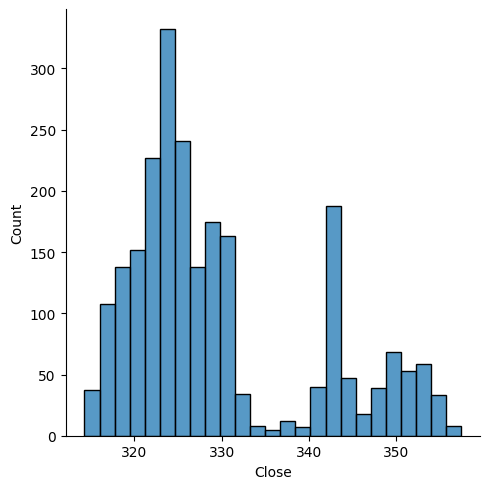

In [ ]:
sns.displot(df['Close'])

<Axes: ylabel='Close'>

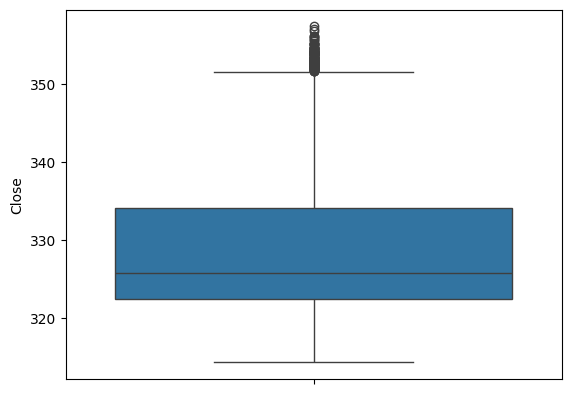

In [ ]:
sns.boxplot(df['Close'])

In [ ]:
df['Close'].skew()

np.float64(0.9447397389145956)

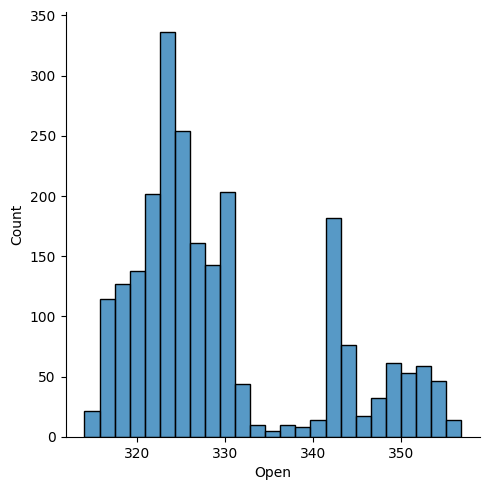

In [ ]:
sns.displot(df['Open'])

<Axes: ylabel='Open'>

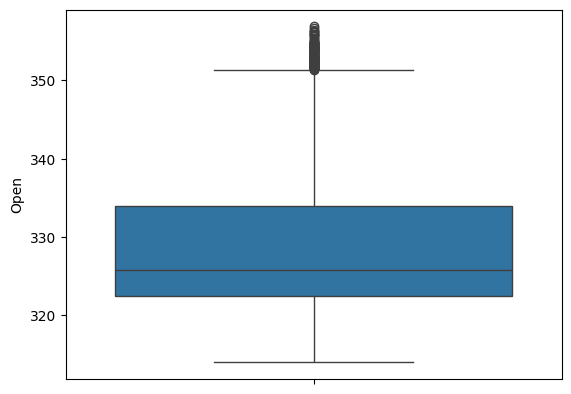

In [ ]:
sns.boxplot(df['Open'])

In [ ]:
df['Open'].skew()

np.float64(0.9440519041846259)

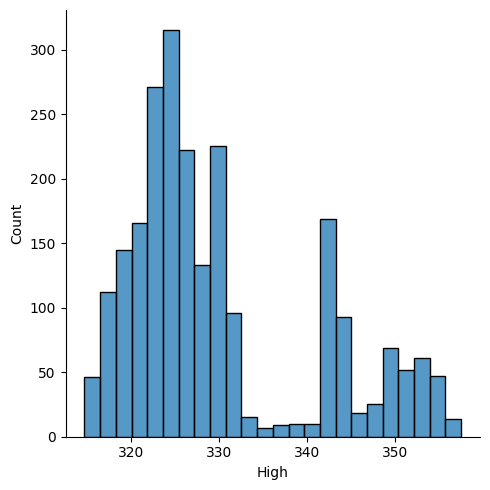

In [ ]:
sns.displot(df['High'])

<Axes: ylabel='High'>

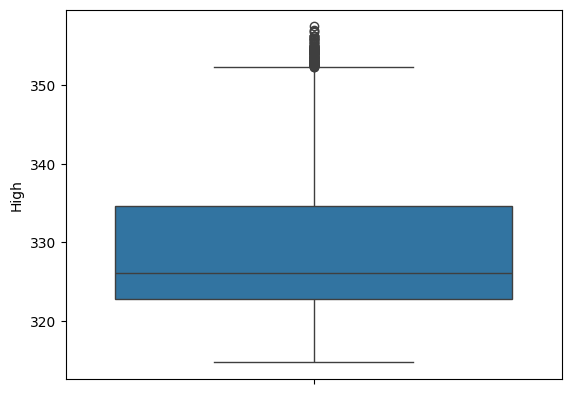

In [ ]:
sns.boxplot(df['High'])

In [ ]:
df['High'].skew()

np.float64(0.9463056203163643)

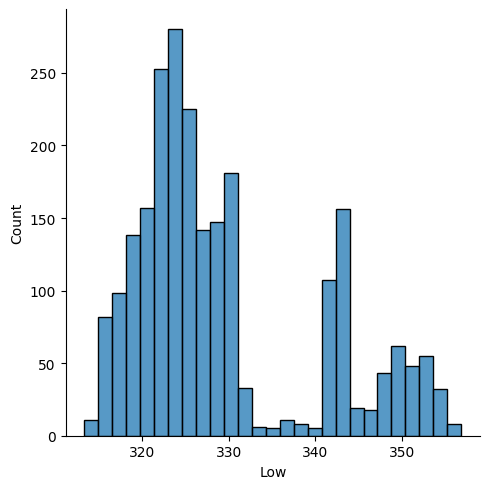

In [ ]:
sns.displot(df['Low'])

<Axes: ylabel='Low'>

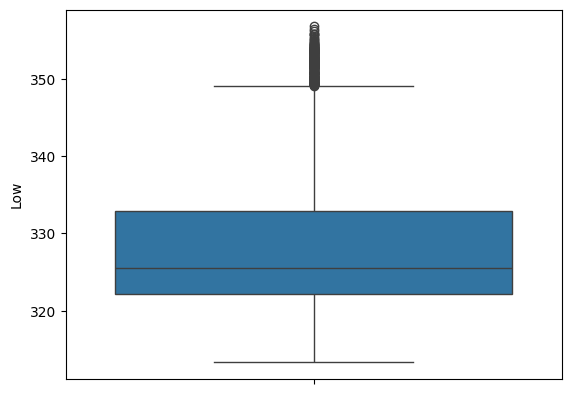

In [ ]:
sns.boxplot(df['Low'])

In [ ]:
df['Low'].skew()

np.float64(0.9406352589378781)

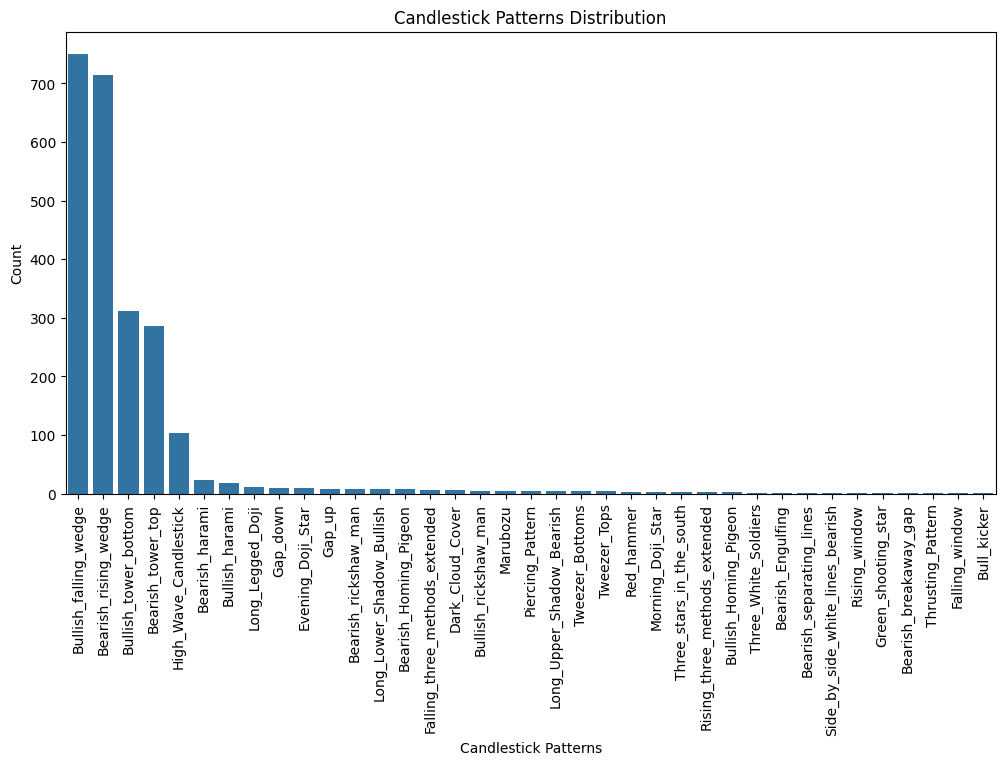

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=df['candlesticks'].value_counts().index,
            y=df['candlesticks'].value_counts())
plt.xticks(rotation=90)
plt.title('Candlestick Patterns Distribution')
plt.xlabel('Candlestick Patterns')
plt.ylabel('Count')
plt.show()

#  Converting categorical data to numerical data

In [ ]:
df=df.drop(columns=['candlesticks'])

In [ ]:
X = df[['Close', 'High', 'Low', 'Open', 'sentimentfinbert', 'sentimenttextblob', 'sentimentvader']]
y = df['signal']

In [ ]:
le=LabelEncoder()
y=le.fit_transform(y)

In [ ]:
sc = StandardScaler()
X = sc.fit_transform(X)

# Feature Scaling

# Train-Test Split

Oversampling the Minority Classes

In [ ]:
smote_tomek = SMOTETomek( random_state=42,sampling_strategy="minority")
X, y = smote_tomek.fit_resample(X, y)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
X_train.shape

(2235, 7)

In [ ]:
X_test.shape

(559, 7)

In [ ]:
y_train.shape

(2235,)

In [ ]:
y_test.shape

(559,)

# Model Training



*   Random Forest Classification



In [ ]:
rfr=RandomForestClassifier(max_depth= None, max_features='sqrt',min_samples_leaf=1,min_samples_split=4,n_estimators=158)

In [ ]:
rfr.fit(X_train,y_train)
y_pred=rfr.predict(X_test)

In [ ]:
accuracy_rfr = accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {accuracy_rfr:.2f}')

Accuracy Score: 0.75


In [ ]:
f1_rfr = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1_rfr:.4f}")

F1 Score: 0.7316


In [ ]:
train_accuracy = rfr.score(X_train, y_train)
test_accuracy = rfr.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.9964
Test Accuracy: 0.7460


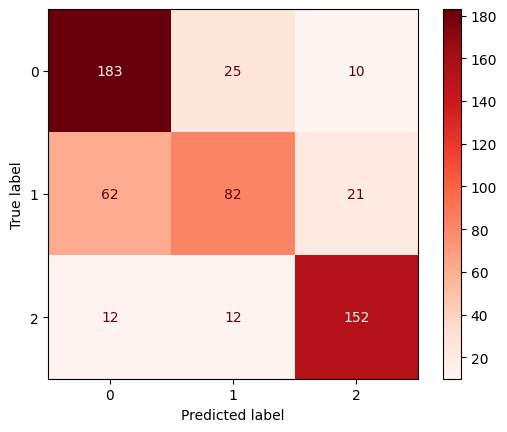

In [ ]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfr.classes_)
disp.plot(cmap='Reds')

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = rfr.predict_proba(X_test)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

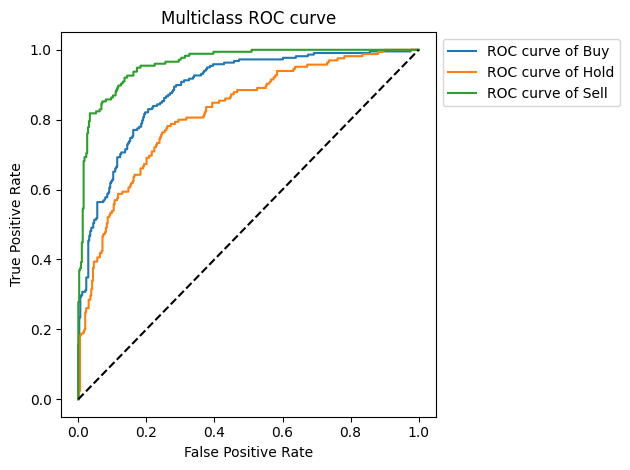

In [ ]:
plt.figure()
for i in range(y_test_bin.shape[1]):
    class_name = le.classes_[i]
    plt.plot(fpr[i], tpr[i],label=f'ROC curve of {class_name}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()



  Hyperparameter-Tuning of Random Forest Classifier



In [ ]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [10, 20, 50, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    scoring='accuracy',
    n_iter=10,
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 50, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e198a207e50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e19885d3b50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e198ab3bf10>},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
print("All Results:")
for mean, params in zip(random_search.cv_results_['mean_test_score'], random_search.cv_results_['params']):
    print(f"Score: {mean:.4f}, Parameters: {params}")

All Results:
Score: 0.6622, Parameters: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 206}
Score: 0.6635, Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 221}
Score: 0.6582, Parameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 187}
Score: 0.6022, Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 230}
Score: 0.6519, Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 591}
Score: 0.6483, Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 376}
Score: 0.6139, Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 352}
Score: 0.6837, Parameters:



*   XGBoost


In [ ]:
xgb=XGBClassifier(objective='multi:softmax')

In [ ]:
xgb.fit(X_train,y_train)
y_pred=xgb.predict(X_test)

In [ ]:
accuracy_xgb=accuracy_score(y_test,y_pred)
print(f'Accuracy Score:{accuracy_xgb:.2f}')

Accuracy Score:0.73


In [ ]:
f1_xgb = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1_xgb:.4f}")

F1 Score: 0.7195


In [ ]:
train_accuracy = xgb.score(X_train, y_train)
test_accuracy = xgb.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.9445
Test Accuracy: 0.7317


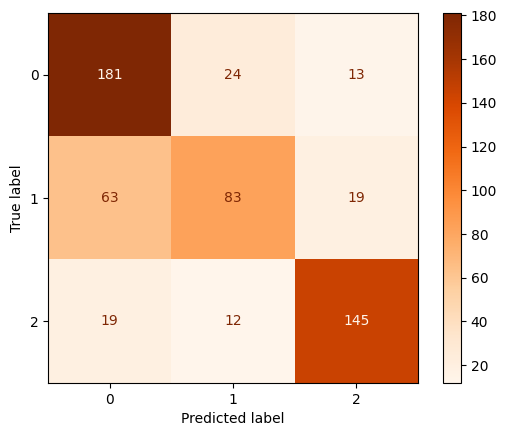

In [ ]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgb.classes_)
disp.plot(cmap='Oranges')

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = xgb.predict_proba(X_test)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

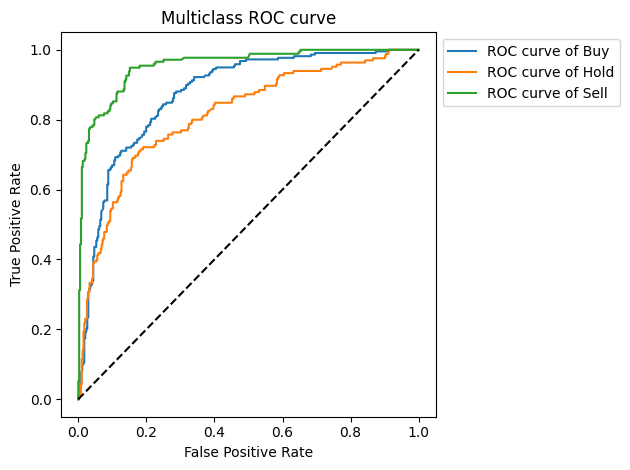

In [ ]:
plt.figure()
for i in range(y_test_bin.shape[1]):
    class_name = le.classes_[i]
    plt.plot(fpr[i], tpr[i],label=f'ROC curve of {class_name}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


*   Gaussian Naive Bayes

In [ ]:
gnb=GaussianNB(var_smoothing=  0.0005808362216819946)

In [ ]:
gnb.fit(X_train,y_train)
y_pred=gnb.predict(X_test)

In [ ]:
accuracy_gnb=accuracy_score(y_test,y_pred)
print(f'Accuracy Score:{accuracy_gnb:.2f}')

Accuracy Score:0.33


In [ ]:
f1_gnb = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1_gnb:.4f}")

F1 Score: 0.2590


In [ ]:
train_accuracy = gnb.score(X_train, y_train)
test_accuracy = gnb.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.3799
Test Accuracy: 0.3309


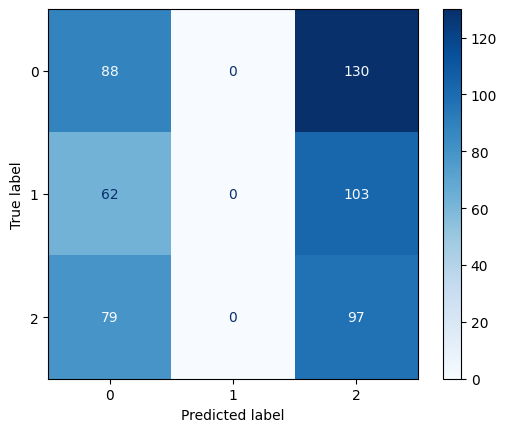

In [ ]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot(cmap='Blues')

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = gnb.predict_proba(X_test)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

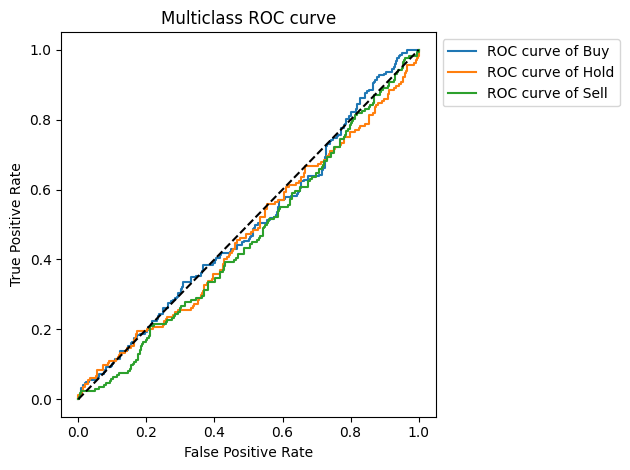

In [ ]:
plt.figure()
for i in range(y_test_bin.shape[1]):
    class_name = le.classes_[i]
    plt.plot(fpr[i], tpr[i],label=f'ROC curve of {class_name}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Hyperparamter-Tuning of Gaussian Naive Bayes

In [ ]:
param_dist = {
    'var_smoothing': uniform(1e-10, 1e-2)
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=gnb,
    param_distributions=param_dist,
    n_iter=10,
    cv=2,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2,
                   estimator=GaussianNB(var_smoothing=0.0005808362216819946),
                   n_jobs=-1,
                   param_distributions={'var_smoothing': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e1a253e3b90>},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
print("All Results:")
for mean, params in zip(random_search.cv_results_['mean_test_score'], random_search.cv_results_['params']):
    print(f"Score: {mean:.4f}, Parameters: {params}")

All Results:
Score: 0.3499, Parameters: {'var_smoothing': np.float64(0.003745401288473625)}
Score: 0.3512, Parameters: {'var_smoothing': np.float64(0.009507143164099162)}
Score: 0.3503, Parameters: {'var_smoothing': np.float64(0.007319939518114051)}
Score: 0.3503, Parameters: {'var_smoothing': np.float64(0.005986584941970366)}
Score: 0.3499, Parameters: {'var_smoothing': np.float64(0.0015601865044243652)}
Score: 0.3499, Parameters: {'var_smoothing': np.float64(0.0015599453033620266)}
Score: 0.3494, Parameters: {'var_smoothing': np.float64(0.0005808362216819946)}
Score: 0.3508, Parameters: {'var_smoothing': np.float64(0.008661761557749352)}
Score: 0.3503, Parameters: {'var_smoothing': np.float64(0.006011150217432088)}
Score: 0.3503, Parameters: {'var_smoothing': np.float64(0.007080725877960455)}




*   Support Vector Classifier(SVC)




In [ ]:
svc=SVC(C= 6.969276354507875, coef0= 0.7000778765841014, degree= 2, gamma='scale', kernel='linear',probability=True)

In [ ]:
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)

In [ ]:
accuracy_svc=accuracy_score(y_test,y_pred)
print(f'Accuracy Score:{accuracy_svc:.2f}')

Accuracy Score:0.66


In [ ]:
f1_svc = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1_svc:.4f}")

F1 Score: 0.5625


In [ ]:
train_accuracy = svc.score(X_train, y_train)
test_accuracy = svc.score(X_test, y_test)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.6957
Test Accuracy: 0.6601


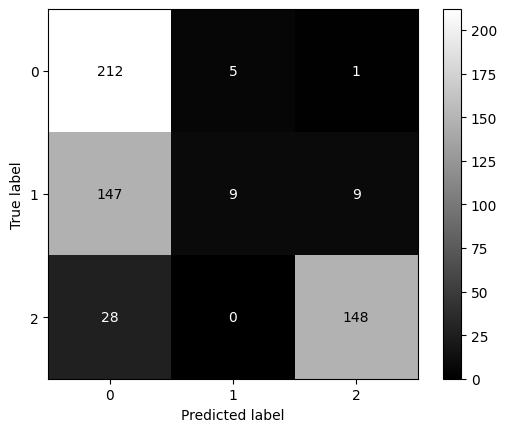

In [ ]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svc.classes_)
disp.plot(cmap='gray')

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = svc.predict_proba(X_test)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

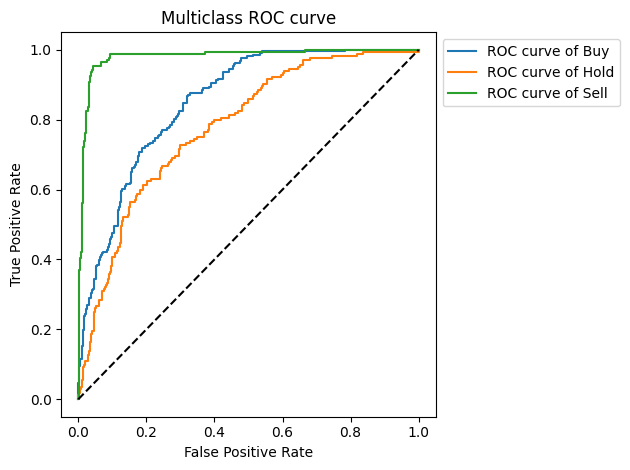

In [ ]:
plt.figure()
for i in range(y_test_bin.shape[1]):
    class_name = le.classes_[i]
    plt.plot(fpr[i], tpr[i],label=f'ROC curve of {class_name}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()



*  Hyperparameter Tuning of SVC



In [ ]:
param_dist = {
    'C': uniform(6.5, 0.5),
    'coef0': uniform(0.7, 0.1),
    'degree': randint(2, 3),
    'gamma': ['auto', 'scale'],
    'kernel': ['linear']
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2,
                   estimator=SVC(C=6.969276354507875, coef0=0.7000778765841014,
                                 degree=2, kernel='linear', probability=True),
                   n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e197ff0f450>,
                                        'coef0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e197ef2fdd0>,
                                        'degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e198e9c2f50>,
                                        'gamma': ['auto', 'scale'],
                                        'kernel': ['linear']},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
print("All Results:")
for mean, params in zip(random_search.cv_results_['mean_test_score'], random_search.cv_results_['params']):
    print(f"Score: {mean:.4f}, Parameters: {params}")

All Results:
Score: 0.6774, Parameters: {'C': np.float64(6.687270059423681), 'coef0': np.float64(0.7950714306409916), 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
Score: 0.6778, Parameters: {'C': np.float64(6.889845500136385), 'coef0': np.float64(0.7596850157946486), 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Score: 0.6770, Parameters: {'C': np.float64(6.577997260168101), 'coef0': np.float64(0.7058083612168199), 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Score: 0.6774, Parameters: {'C': np.float64(6.666854305569511), 'coef0': np.float64(0.714286681792194), 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
Score: 0.6778, Parameters: {'C': np.float64(6.510292247147901), 'coef0': np.float64(0.7969909852161994), 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Score: 0.6778, Parameters: {'C': np.float64(6.969276354507875), 'coef0': np.float64(0.7000778765841014), 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Score: 0.6770, Parameters: {'C': np.float64(6.59170225



*   Stochastic Gradient Descent(SGD)



In [ ]:
sgd = SGDClassifier(alpha= 0.001819249672071006, eta0= 0.01844045098534338, learning_rate= 'adaptive', max_iter= 1500, penalty= 'l1', tol= 1.706630521971741e-05,loss='log_loss')

In [ ]:
sgd.fit(X_train,y_train)
y_pred=sgd.predict(X_test)

In [ ]:
accuracy_sgd=accuracy_score(y_test,y_pred)
print(f'Accuracy Score:{accuracy_sgd:.2f}')

Accuracy Score:0.67


In [ ]:
f1_sgd = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1_sgd:.4f}")

F1 Score: 0.5435


In [ ]:
train_accuracy = sgd.score(X_train, y_train)
test_accuracy = sgd.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.7101
Test Accuracy: 0.6655


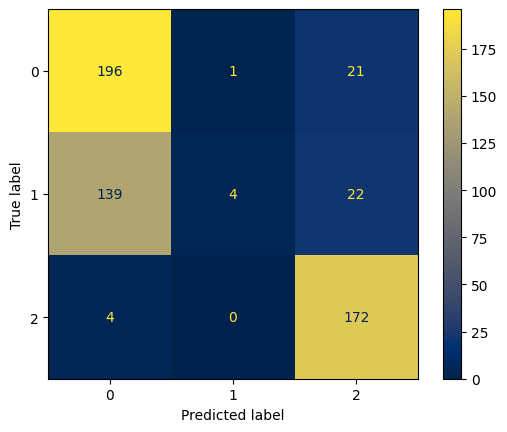

In [ ]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sgd.classes_)
disp.plot(cmap='cividis')

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = sgd.predict_proba(X_test)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

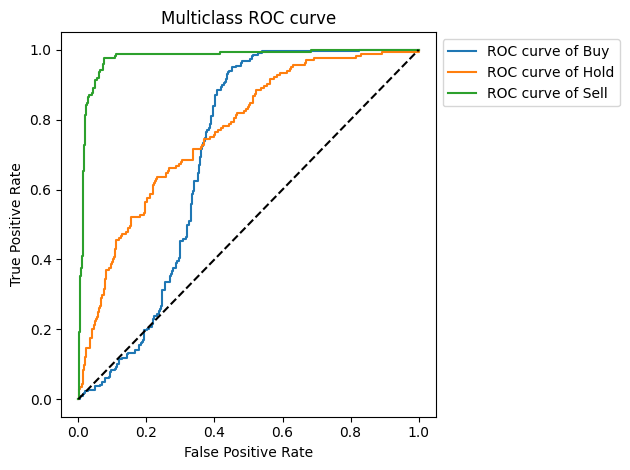

In [ ]:
plt.figure()
for i in range(y_test_bin.shape[1]):
    class_name = le.classes_[i]
    plt.plot(fpr[i], tpr[i],label=f'ROC curve of {class_name}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Hyperparameter-Tuning of Stochastic Gradient Descent

In [ ]:
param_dist = {
    'alpha': uniform(1e-6, 1e-2),
    'max_iter': randint(100, 1000),
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': uniform(1e-4, 1e-1),
    'tol': uniform(1e-5, 1e-3)
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=sgd,
    param_distributions=param_dist,
    n_iter=10,
    cv=2,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2,
                   estimator=SGDClassifier(alpha=0.001819249672071006,
                                           eta0=0.01844045098534338,
                                           learning_rate='adaptive',
                                           loss='log_loss', max_iter=1500,
                                           penalty='l1',
                                           tol=1.706630521971741e-05),
                   n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e197fed0550>,
                                        'eta0': <scipy.stats._distn_infrastruc...us_frozen object at 0x7e197fd6bf90>,
                                        'learning_rate': ['constant', 'optimal',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e197fd1cdd0>,
                                        'penalty': ['l2', 'l1', 'elasticnet'],
                                        'tol': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e197fe950d0>},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
print("All Results:")
for mean, params in zip(random_search.cv_results_['mean_test_score'], random_search.cv_results_['params']):
    print(f"Score: {mean:.4f}, Parameters: {params}")

All Results:
Score: 0.3794, Parameters: {'alpha': np.float64(0.003746401188473625), 'eta0': np.float64(0.09517143064099162), 'learning_rate': 'invscaling', 'max_iter': 171, 'penalty': 'l2', 'tol': np.float64(0.000606850157946487)}
Score: 0.3736, Parameters: {'alpha': np.float64(0.004459327528535912), 'eta0': np.float64(0.010097491581800289), 'learning_rate': 'invscaling', 'max_iter': 187, 'penalty': 'l2', 'tol': np.float64(0.0006111150117432088)}
Score: 0.3781, Parameters: {'alpha': np.float64(0.007081725777960455), 'eta0': np.float64(0.0021584494295802444), 'learning_rate': 'optimal', 'max_iter': 443, 'penalty': 'l1', 'tol': np.float64(0.00022233911067827617)}
Score: 0.6653, Parameters: {'alpha': np.float64(0.001819249672071006), 'eta0': np.float64(0.01844045098534338), 'learning_rate': 'adaptive', 'max_iter': 413, 'penalty': 'l1', 'tol': np.float64(1.706630521971741e-05)}
Score: 0.3767, Parameters: {'alpha': np.float64(0.00023162425041415758), 'eta0': np.float64(0.05257746602583892),

Logistic Regression

In [ ]:
lr=LogisticRegression(C= 59.7850157946487, max_iter= 7265, penalty='l2', solver= 'saga', tol= 0.0006808361216819947)

In [ ]:
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

In [ ]:
accuracy_lr=accuracy_score(y_test,y_pred)
print(f'Accuracy Score:{accuracy_lr:.2f}')

Accuracy Score:0.72


In [ ]:
f1_lr = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1_lr:.4f}")

F1 Score: 0.6971


In [ ]:
train_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.7579
Test Accuracy: 0.7209


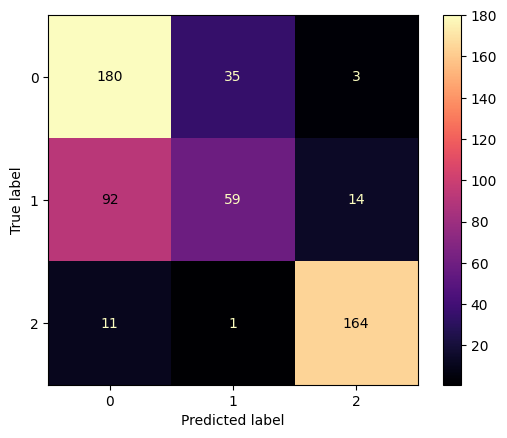

In [ ]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lr.classes_)
disp.plot(cmap='magma')

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = lr.predict_proba(X_test)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

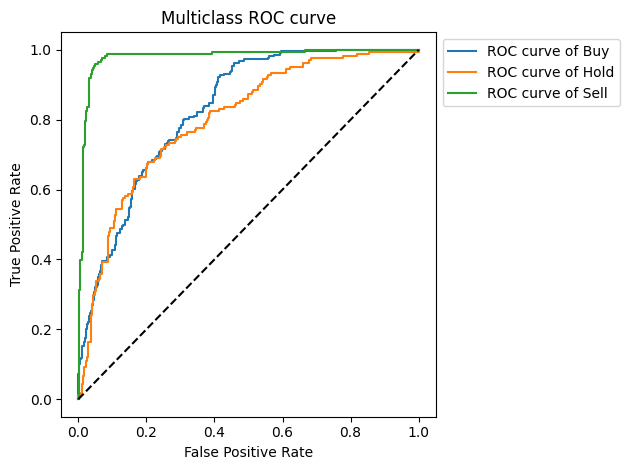

In [ ]:
plt.figure()
for i in range(y_test_bin.shape[1]):
    class_name = le.classes_[i]
    plt.plot(fpr[i], tpr[i],label=f'ROC curve of {class_name}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Hyperparameter-Tuning of Logistic Regression

In [ ]:
param_dist = {
    'C': uniform(0.1, 100),
    'max_iter': randint(1000, 10000),
    'penalty': ['l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'tol': uniform(1e-4, 1e-2)
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    n_iter=10,
    cv=2,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


14 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver

RandomizedSearchCV(cv=2,
                   estimator=LogisticRegression(C=59.7850157946487,
                                                max_iter=7265, solver='saga',
                                                tol=0.0006808361216819947),
                   n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e197fd2aed0>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e19881f7690>,
                                        'penalty': ['l2', 'elasticnet'],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'saga'],
                                        'tol': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e197fd84590>},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
print("All Results:")
for mean, params in zip(random_search.cv_results_['mean_test_score'], random_search.cv_results_['params']):
    print(f"Score: {mean:.4f}, Parameters: {params}")

All Results:
Score: 0.7186, Parameters: {'C': np.float64(37.55401188473625), 'max_iter': 1860, 'penalty': 'l2', 'solver': 'saga', 'tol': np.float64(0.007896910002727693)}
Score: 0.7499, Parameters: {'C': np.float64(59.7850157946487), 'max_iter': 7265, 'penalty': 'l2', 'solver': 'saga', 'tol': np.float64(0.0006808361216819947)}
Score: nan, Parameters: {'C': np.float64(86.7176145774935), 'max_iter': 9322, 'penalty': 'elasticnet', 'solver': 'lbfgs', 'tol': np.float64(0.009799098521619943)}
Score: nan, Parameters: {'C': np.float64(83.34426408004217), 'max_iter': 7949, 'penalty': 'elasticnet', 'solver': 'lbfgs', 'tol': np.float64(0.0062748150962771655)}
Score: nan, Parameters: {'C': np.float64(61.26531604882809), 'max_iter': 7396, 'penalty': 'elasticnet', 'solver': 'lbfgs', 'tol': np.float64(0.003012291401980419)}
Score: nan, Parameters: {'C': np.float64(61.28528947223795), 'max_iter': 8849, 'penalty': 'elasticnet', 'solver': 'saga', 'tol': np.float64(0.004660699842170359)}
Score: nan, Para

KNeighborsClassifier

In [ ]:
knn=KNeighborsClassifier(leaf_size= 39, metric= 'euclidean', n_neighbors= 2, p= 4, weights= 'distance')

In [ ]:
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

In [ ]:
accuracy_knn=accuracy_score(y_test,y_pred)
print(f'Accuracy Score:{accuracy_knn:.2f}')

Accuracy Score:0.82


In [ ]:
f1_knn = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1_knn:.4f}")

F1 Score: 0.8080


In [ ]:
train_accuracy = knn.score(X_train, y_train)
test_accuracy = knn.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 1.0000
Test Accuracy: 0.8175


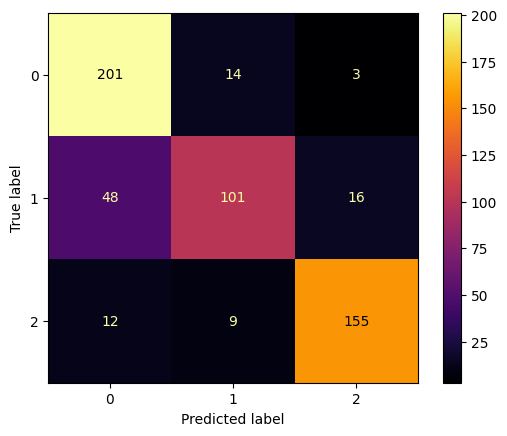

In [ ]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn.classes_)
disp.plot(cmap='inferno')

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = knn.predict_proba(X_test)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

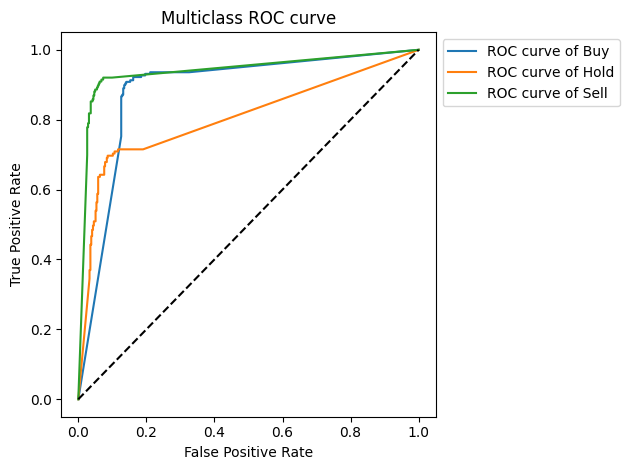

In [ ]:
plt.figure()
for i in range(y_test_bin.shape[1]):
    class_name = le.classes_[i]
    plt.plot(fpr[i], tpr[i],label=f'ROC curve of {class_name}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Hyperparameter-Tuning of KneighborsClassifier

In [ ]:
param_dist = {
    'n_neighbors': randint(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'p': randint(1, 5),
    'leaf_size': randint(10, 100)
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_dist,
    n_iter=10,
    cv=2,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2,
                   estimator=KNeighborsClassifier(leaf_size=39,
                                                  metric='euclidean',
                                                  n_neighbors=2, p=4,
                                                  weights='distance'),
                   n_jobs=-1,
                   param_distributions={'leaf_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e197fb152d0>,
                                        'metric': ['minkowski', 'euclidean',
                                                   'manhattan'],
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e197fa20e50>,
                                        'p': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e197fa3e150>,
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
print("All Results:")
for mean, params in zip(random_search.cv_results_['mean_test_score'], random_search.cv_results_['params']):
    print(f"Score: {mean:.4f}, Parameters: {params}")

All Results:
Score: 0.6729, Parameters: {'leaf_size': 61, 'metric': 'minkowski', 'n_neighbors': 15, 'p': 3, 'weights': 'distance'}
Score: 0.6277, Parameters: {'leaf_size': 70, 'metric': 'minkowski', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
Score: 0.5825, Parameters: {'leaf_size': 96, 'metric': 'manhattan', 'n_neighbors': 11, 'p': 4, 'weights': 'uniform'}
Score: 0.7235, Parameters: {'leaf_size': 33, 'metric': 'manhattan', 'n_neighbors': 2, 'p': 4, 'weights': 'distance'}
Score: 0.7298, Parameters: {'leaf_size': 39, 'metric': 'euclidean', 'n_neighbors': 2, 'p': 4, 'weights': 'distance'}
Score: 0.6689, Parameters: {'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 12, 'p': 2, 'weights': 'distance'}
Score: 0.6828, Parameters: {'leaf_size': 98, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 4, 'weights': 'distance'}
Score: 0.5476, Parameters: {'leaf_size': 69, 'metric': 'manhattan', 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
Score: 0.6877, Parameters: {'leaf_size': 64, 'met



*   MLP Classifier



In [ ]:
mlp = MLPClassifier(max_iter=5000)

In [ ]:
mlp.fit(X_train,y_train)
y_pred=mlp.predict(X_test)

In [ ]:
accuracy_mlp=accuracy_score(y_test,y_pred)
print(f'Accuracy Score:{accuracy_mlp:.2f}')

Accuracy Score:0.73


In [ ]:
f1_mlp= f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1_mlp:.4f}")

F1 Score: 0.7041


In [ ]:
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.7579
Test Accuracy: 0.7299


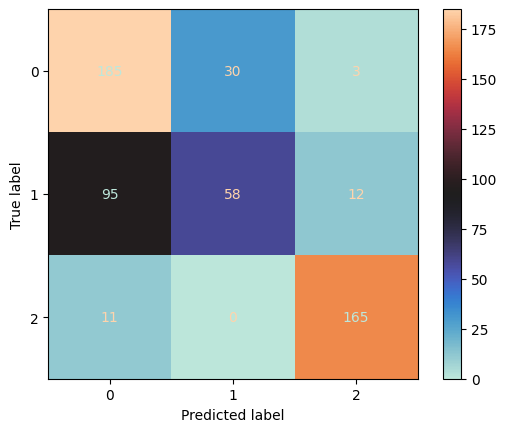

In [ ]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=mlp.classes_)
disp.plot(cmap='icefire')

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = mlp.predict_proba(X_test)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

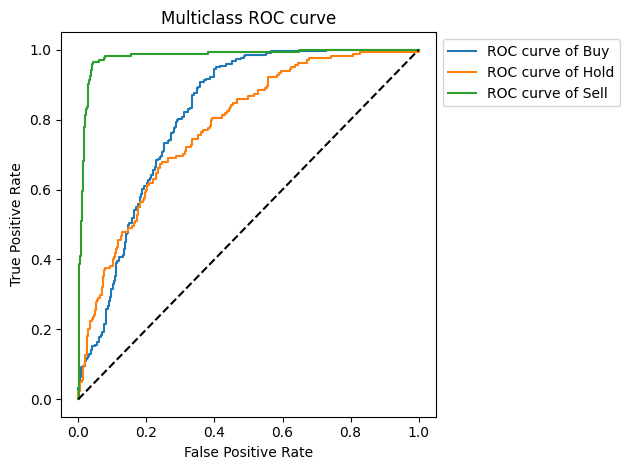

In [ ]:
plt.figure()
for i in range(y_test_bin.shape[1]):
    class_name = le.classes_[i]
    plt.plot(fpr[i], tpr[i],label=f'ROC curve of {class_name}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()



*   Decision Tree Classifier



In [ ]:
dt=DecisionTreeClassifier(splitter= 'best', min_samples_split= 15, min_samples_leaf= 6, max_features= 'sqrt', max_depth= 19, criterion= 'log_loss')

In [ ]:
dt.fit(X_train,y_train)
y_pred=dt.predict(X_test)

In [ ]:
accuracy_dt=accuracy_score(y_test,y_pred)
print(f'Accuracy Score:{accuracy_dt:.2f}')

Accuracy Score:0.43


In [ ]:
f1_dt = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1_dt:.4f}")

F1 Score: 0.3772


In [ ]:
train_accuracy = dt.score(X_train, y_train)
test_accuracy = dt.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.5092
Test Accuracy: 0.4347


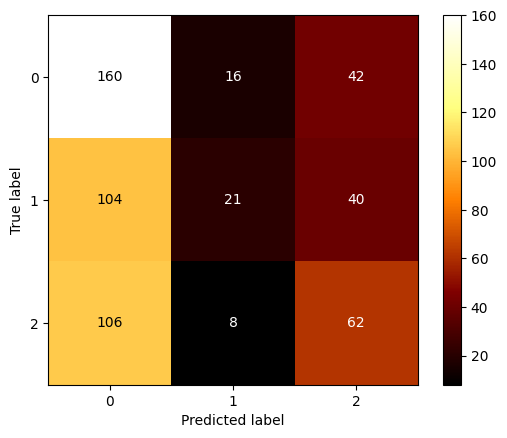

In [ ]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt.classes_)
disp.plot(cmap='afmhot')

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = dt.predict_proba(X_test)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

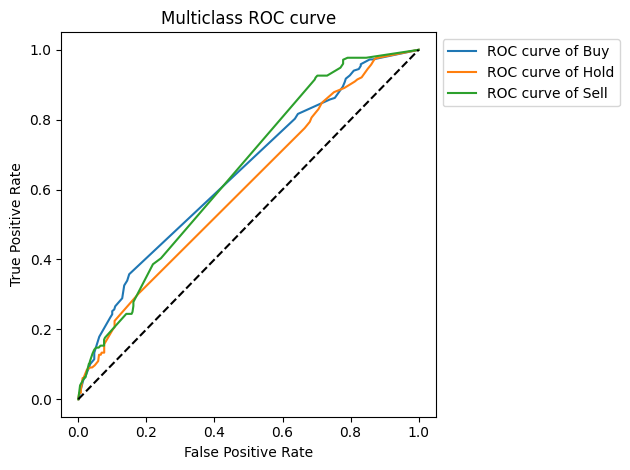

In [ ]:
plt.figure()
for i in range(y_test_bin.shape[1]):
    class_name = le.classes_[i]
    plt.plot(fpr[i], tpr[i],label=f'ROC curve of {class_name}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Hyperparamter Tuning of Decision Tree

In [ ]:
param_dist = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": [None] + list(np.arange(1, 20)),
    "min_samples_split": np.arange(2, 20),
    "min_samples_leaf": np.arange(1, 20),
    "max_features": [None, "sqrt", "log2"]
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2,
                   estimator=DecisionTreeClassifier(criterion='log_loss',
                                                    max_depth=19,
                                                    max_features='sqrt',
                                                    min_samples_leaf=6,
                                                    min_samples_split=15),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [None, np.int64(1),
                                                      np.int64(2), np.int64(3),
                                                      np.int64(4), np.int64(5),
                                                      np.int64(6), np.int64(7),
                                                      np.int64(8), np.int64(9)...
                                                      np.int64(13),
                                                      np.int64(14),
                                                      np.int64(15),
                                                      np.int64(16),
                                                      np.int64(17),
                                                      np.int64(18),
                                                      np.int64(19)],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
print("All Results:")
for mean, params in zip(random_search.cv_results_['mean_test_score'], random_search.cv_results_['params']):
    print(f"Score: {mean:.4f}, Parameters: {params}")

All Results:
Score: 0.4801, Parameters: {'splitter': 'best', 'min_samples_split': np.int64(15), 'min_samples_leaf': np.int64(6), 'max_features': 'sqrt', 'max_depth': np.int64(19), 'criterion': 'log_loss'}
Score: 0.4040, Parameters: {'splitter': 'random', 'min_samples_split': np.int64(15), 'min_samples_leaf': np.int64(2), 'max_features': 'log2', 'max_depth': np.int64(7), 'criterion': 'gini'}
Score: 0.5123, Parameters: {'splitter': 'best', 'min_samples_split': np.int64(18), 'min_samples_leaf': np.int64(5), 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini'}
Score: 0.4474, Parameters: {'splitter': 'best', 'min_samples_split': np.int64(9), 'min_samples_leaf': np.int64(12), 'max_features': 'sqrt', 'max_depth': np.int64(10), 'criterion': 'log_loss'}
Score: 0.4282, Parameters: {'splitter': 'random', 'min_samples_split': np.int64(19), 'min_samples_leaf': np.int64(5), 'max_features': 'sqrt', 'max_depth': np.int64(18), 'criterion': 'log_loss'}
Score: 0.4506, Parameters: {'splitter': 

Multi-Model

In [ ]:
models=[
    ('svc',svc),
    ('gnb',gnb),
    ('lr',lr),
    ('dt',dt),

]

In [ ]:
model=StackingClassifier(estimators=models,final_estimator=rfr,cv=10)

In [ ]:
model.fit(X_train,y_train)

StackingClassifier(cv=10,
                   estimators=[('svc',
                                SVC(C=6.969276354507875,
                                    coef0=0.7000778765841014, degree=2,
                                    kernel='linear', probability=True)),
                               ('gnb',
                                GaussianNB(var_smoothing=0.0005808362216819946)),
                               ('lr',
                                LogisticRegression(C=59.7850157946487,
                                                   max_iter=7265, solver='saga',
                                                   tol=0.0006808361216819947)),
                               ('dt',
                                DecisionTreeClassifier(criterion='log_loss',
                                                       max_depth=19,
                                                       max_features='sqrt',
                                                       min_samples_leaf=6,
                                                       min_samples_split=15))],
                   final_estimator=RandomForestClassifier(min_samples_split=4,
                                                          n_estimators=158))

In [ ]:
y_pred=model.predict(X_test)

# Evaluating model

In [ ]:
print(classification_report(y_test, y_pred,zero_division=0))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       218
           1       0.62      0.54      0.58       165
           2       0.90      0.97      0.93       176

    accuracy                           0.75       559
   macro avg       0.75      0.75      0.75       559
weighted avg       0.75      0.75      0.75       559



In [ ]:
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.8492
Test Accuracy: 0.7549


In [ ]:
accuracy_model = accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {accuracy_model:.2f}')

Accuracy Score: 0.75


In [ ]:
f1_model = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1_model:.4f}")

F1 Score: 0.7473


# Visualizations

In [ ]:
cm = confusion_matrix(y_test, y_pred)

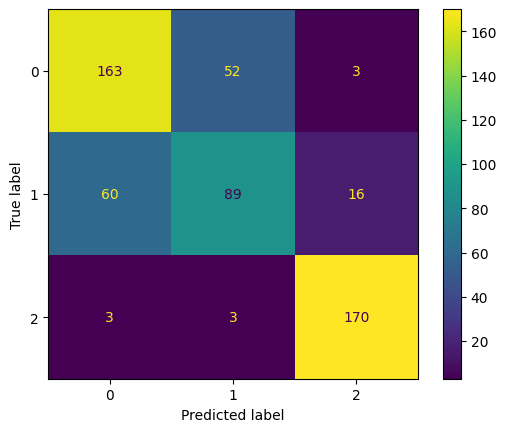

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = model.predict_proba(X_test)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

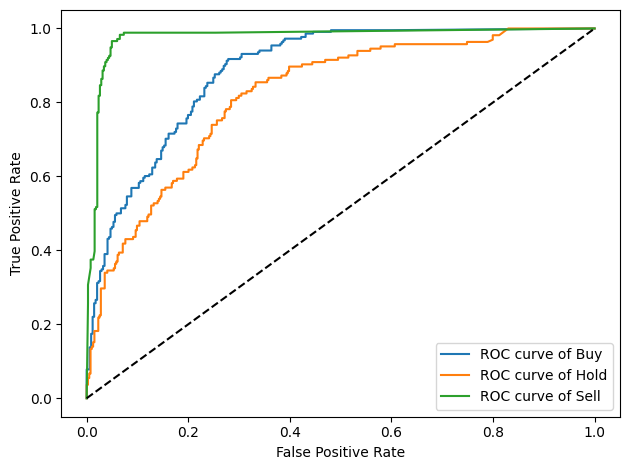

In [ ]:
plt.figure()
for i in range(y_test_bin.shape[1]):
    class_name = le.classes_[i]
    plt.plot(fpr[i], tpr[i],label=f'ROC curve of {class_name}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

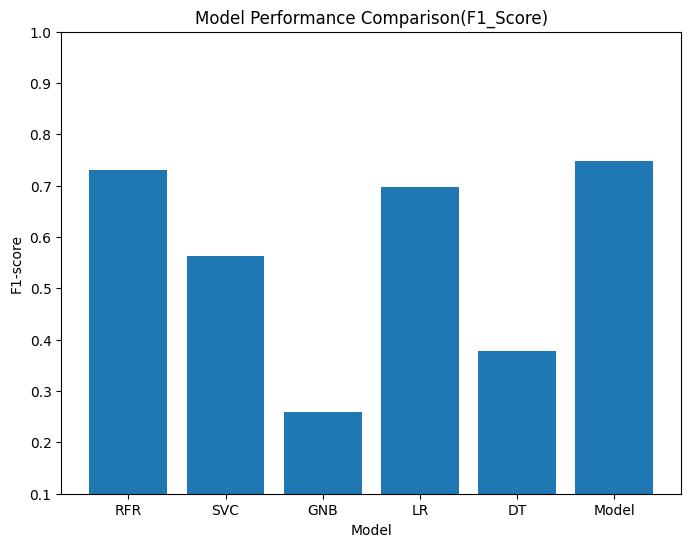

In [ ]:
models = ['RFR','SVC','GNB','LR','DT','Model']
accuracies = [f1_rfr,f1_svc,f1_gnb, f1_lr,f1_dt,f1_model]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies)
plt.title('Model Performance Comparison(F1_Score)')
plt.xlabel('Model')
plt.ylabel('F1-score')
plt.ylim(0.1, 1.0)
plt.show()

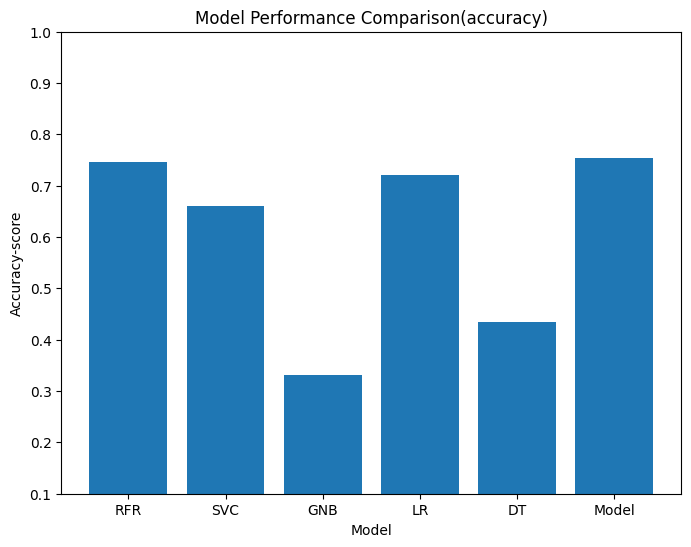

In [ ]:
models = ['RFR','SVC','GNB','LR','DT','Model']
accuracies = [accuracy_rfr,accuracy_svc,accuracy_gnb, accuracy_lr,accuracy_dt,accuracy_model]
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies)
plt.title('Model Performance Comparison(accuracy)')
plt.xlabel('Model')
plt.ylabel('Accuracy-score')
plt.ylim(0.1, 1.0)
plt.show()